# ResNet 50: Classify All Characters
In this notebook, we use a modified version of ResNet 50 (changed from two dimensional convolutions to one dimensional convolutions) to classify all characters in Melee. We used the GitHub repo [ResNet-PyTorch](https://github.com/JayPatwardhan/ResNet-PyTorch) as our base code and modified it to suit our needs. The dataloader, training function, and prediction functions are in ``slp_package/pytorch_functions.py``. 

The dataset consists of 40,000 one minute segments for each of the 25 characters in Melee. After eight epochs we achived an accuracy of 98.37% on the test set. The model had trouble differentiating between Dr. Mario and Mario and Pikachu and Pichu. We believe that this is due to the fact that the characters are very similar in terms of their moveset and playstyle as well as there being a lot of overlap in the training segments for these characters.

---
## Imports

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc
import time
import random



import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions
from slp_package.slp_functions import create_merged_game_data_df

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [14]:
df = create_merged_game_data_df(['ranked','mango','public'])

In [15]:
df.columns


Index(['source', 'source_path_prefix', 'source_path_suffix', 'length',
       'num_players', 'is_teams', 'player_1_port', 'player_1_character_name',
       'player_1_type_name', 'player_1_stocks', 'player_1_costume',
       'player_1_team_value', 'player_1_ucf_shield_drop_name', 'player_1_tag',
       'player_1_display_name', 'player_2_port', 'player_2_character_name',
       'player_2_type_name', 'player_2_stocks', 'player_2_costume',
       'player_2_team_value', 'player_2_ucf_shield_drop_name', 'player_2_tag',
       'player_2_display_name', 'random_seed', 'slippi', 'stage_name',
       'is_pal', 'is_frozen_ps', 'end_method_name', 'lras_initiator',
       'conclusive', 'winning_player', 'date', 'duration', 'platform',
       'player_1_netplay_code', 'player_1_netplay_name',
       'player_2_netplay_code', 'player_2_netplay_name', 'console_name',
       'all_data_df_common_path', 'inputs_df_common_path',
       'inputs_np_common_path', 'player_1_all_data_df_sub_path',
       'player_

In [16]:
df['player_1_display_name'].value_counts()

                   99186
Platinum Player    47335
Master Player      39195
Diamond Player     29613
mang               14142
                   ...  
AV                     1
Zuppy                  1
tk                     1
DawsonTruu             1
Bink                   1
Name: player_1_display_name, Length: 257, dtype: int64

In [17]:
df['length'].sum() / (60)

41459841.06666667

## Function to assess the model
We use this function to create confusion matrices and calculate various metrics for the model.

In [18]:
def asses_model(
    model_name, 
    y_pred, 
    y_test, 
    labels_order, 
    plot_roc=False
):
    """
    Assess a classification model using multiple metrics, confusion matrices,
    classification report, and optional ROC curve visualization.

    Parameters:
    -----------
    model_name : str
        The name of the model to display in plots.
    y_pred : array-like
        Model predictions.
    y_test : array-like
        True labels.
    labels_order : list
        Labels in a specific order you want for confusion matrices and bar charts.
    plot_roc : bool, default = False
        Whether to plot the ROC curves (for binary or multi-class classification).
    """

    # --- 1. Metrics: Accuracy & Cohen Kappa ---
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print(f'\nModel: {model_name}')
    print(f'Accuracy:          {accuracy:.4f}')
    print(f'Cohen Kappa Score: {kappa:.4f}')

    # --- 2. Classification Report ---
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels_order))

    # --- 3. Over/Under Prediction Bar Chart ---
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {
        k: v / counts_test[np.where(unique_test == k)[0][0]] 
        for k, v in zip(unique_pred, counts_pred)
        if k in unique_test
    }

    # Calculate the percent the model over or under predicted the labels 
    # using the specified label order
    sorted_values = [
        normalized_counts_pred[k] - 1 
        if k in normalized_counts_pred 
        else 0 
        for k in labels_order
    ]

    plt.figure(figsize=(2*len(labels_order), 8))
    plt.bar(labels_order, sorted_values,
            color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over/Under Predicted Labels', fontsize=50)
    plt.xlabel('Labels', fontsize=40)
    plt.ylabel('Over/Under', fontsize=40)
    # make the x-ticks bigger and vertical
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    # Center y-axis
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # --- 4. Confusion Matrices (Not Normalized, Normalized by True, Normalized by Pred) ---
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order)+5, len(labels_order)+5))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, 
            labels=labels_order,
            normalize=norm, 
            xticks_rotation='vertical', 
            ax=ax
        )
        title_str = 'Not Normalized' if norm is None else f'Normalized by {norm}'
        ax.set_title(f'{model_name} Confusion Matrix ({title_str})', fontsize=40)
        ax.set_xlabel('Predicted Label', fontsize=30)
        ax.set_ylabel('True Label', fontsize=30)
        # make the y an x ticks bigger
        ax.yaxis.set_tick_params(labelsize=20)
        ax.xaxis.set_tick_params(labelsize=20)
        plt.tight_layout()
        plt.show()

    # --- 5. (Optional) Plot ROC Curves ---
    if plot_roc:
        # This approach can work for both binary and multi-class problems
        # For multi-class, we do one-vs-rest
        try:
            # Convert labels to one-hot encoding for multi-class
            # If you already have binary labels (0,1) or one-hot encoding, adjust accordingly.
            from sklearn.preprocessing import label_binarize
            n_classes = len(labels_order)
            y_test_binarized = label_binarize(y_test, classes=labels_order)
            y_pred_binarized = label_binarize(y_pred, classes=labels_order)

            plt.figure(figsize=(8, 6))
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, 
                         label=f'Class {labels_order[i]} (AUC = {roc_auc:.2f})')
            
            # Micro-average ROC curve
            fpr_micro, tpr_micro, _ = roc_curve(
                y_test_binarized.ravel(), 
                y_pred_binarized.ravel()
            )
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            plt.plot(fpr_micro, tpr_micro,
                     label=f'Micro-average (AUC = {roc_auc_micro:.2f})',
                     linestyle='--', color='black')

            plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=30)
            plt.ylabel('True Positive Rate', fontsize=30)
            plt.title(f'{model_name} ROC Curves', fontsize=40)
            plt.legend(loc='lower right')
            plt.show()

        except Exception as e:
            print(f"Could not plot ROC curves: {e}")


## Create the training and test sets
We use the InputDataSet class to create the training and test sets. First we define the parameters that will be passed into the class.

In [19]:
# We want to take data from all three datasources.
source_data = ['ranked','public','mango']

# Restrict the games to those that are played on competitive stages, have only 2 players, and are conclusive.
general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True]
}

# We will be classifying what character the player is playing, so we need to include that in the features we want to extract. 
# We want to restrict to games where the player is humans.
player_features = {
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    'type_name': ['HUMAN'] 
}

# We make sure the opponent is also a human.
opposing_player_features = {
    'type_name': ['HUMAN']
}

# The label we want to train on is the character the player is playing.
# We must include the feature we wish to train on in one of the previous feature dictionaries.
label_info = {
    'source': ['player'], 
    'feature': ['character_name']
}

Here is an example of another classification task. Does Mang0's playstyle change when he is playing againt two players who play the same character. Here we try to tell whether Mang0's Falco is playing against Kodorin or Zain.

In [20]:
# # We want to take data from Mang0's dataset.
# source_data = ['mango']

# # Restrict the games to those that are played on competitive stages, have only 2 players, and are conclusive.
# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }

# # Take games where Mang0 is playing as Falco.
# player_features = {
#     'netplay_code': ['MANG#0'],
#     'character_name': ['FALCO'],
#     'type_name': ['HUMAN']  
# }

# # Take games where Kodorin or Zain are playing as Marth.
# opposing_player_features = {
#     'character_name': ['MARTH'],
#     'netplay_code': ['KOD#0', 'ZAIN#0'],
#     'type_name': ['HUMAN']
# }

# # Classify which of Kodorin or Zain Mang0 is playing against.
# label_info = {
#     'source': ['opposing_player'], 
#     'feature': ['netplay_code']
# }

``InputDataSet`` creates a DataFrame that contians the features we specify in the ``features`` parameters. The columns are renamed from `player_1` and `player_2` to `player` and `opposing_player`. The DataFrame contains the path to the numpy array that contains the player inputs we wish to train the model on. It also contains a column that has the label we wish to predict. Length is included so the dataset can caluclate how many segments we can get from each game.

In [21]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)
dataset.dataset.head()


/workspace/slp_jaspar/resnet_classify/../slp_package/input_dataset.py:113: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


stage_name  num_players conclusive player_character_name  \
0   FINAL_DESTINATION            2       True                 FALCO   
1   FINAL_DESTINATION            2       True                 FALCO   
2     POKEMON_STADIUM            2       True                 MARTH   
3  FOUNTAIN_OF_DREAMS            2       True                   FOX   
4   FINAL_DESTINATION            2       True                 FALCO   

  player_type_name opposing_player_type_name  \
0            HUMAN                     HUMAN   
1            HUMAN                     HUMAN   
2            HUMAN                     HUMAN   
3            HUMAN                     HUMAN   
4            HUMAN                     HUMAN   

                           player_inputs_np_sub_path  length labels  
0  mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...    5606  FALCO  
1  mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...    5754  FALCO  
2  mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...    6213  MARTH  
3  mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...    7621    FOX  
4  mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...    7840  FALCO

Here we check to see how many games we have for each label. The Dataset is hugely imbalanced.

In [22]:
print(dataset.dataset['labels'].value_counts())

FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


### Number of Segments per Game

After merging and filtering the Slippi data (based on the user-defined **general_features**, **player_features**, and **opposing_player_features**), the next step is to call:

```python
labels_order = dataset.number_of_segments_per_game(
    segment_length=3600,    # each segment is 3,600 frames (~1 minute)
    num_segments_per_label=40000
)
```

This step attempts to balance the dataset by estimating how much **overlap** we need between segments in order to reach the target number of segments per label. Specifically:

1. **Summing Game Lengths per Label**  
   The function takes the total length of all games for each character (label) and **divides** that by the desired number of segments (40,000). This yields an approximate **shift** for where each subsequent segment should start within the game data.

2. **Overlap Calculation**  
   Because the `segment_length` is fixed (3,600 frames), if the calculated shift is less than 3,600, then **overlapping** segments are created.  
   - For example, for FOX, the shift is approximately 15,075 frames (see “Shift” column in the table). Hence each new segment starts 15,075 frames after the previous segment’s start.  
   - The overlap for FOX is then \( 3600 - 15075 \) frames, but this number is negative, which actually indicates **gaps** rather than overlaps if the shift is larger than the segment length.  
   - Conversely, for a label like PICHU, the shift is only about 41 frames, meaning segments heavily overlap (overlap = \( 3600 - 41 = 3559\) frames).

#### Deterministic Splitting Overview

Once the function computes this shift (and updates an internal `float_num_segments` column), the class proceeds to:
1. **Partition Entire Games** via `divide_games()`.  
   - It assigns games to train/test/val splits without data leakage. Entire games belong to a single split, ensuring the same match never appears in both train and test.
2. **Shuffle Within Each Label** (Optional).  
   - By default, the class shuffles games within each label. To make results strictly reproducible, you can set a specific random seed or remove the shuffle calls.
3. **Segment-Level Splits** via `create_training_dataframe()`.  
   - Each row in the final **train**, **test**, or **val** DataFrame corresponds to a single segment, using the computed shift to map out starting indices.

With this approach, you can build a sequence-based dataset that’s **balanced across characters**, while still respecting the desired train/test/validation split and preserving game boundaries for non-leaky partitioning.
```


In [23]:
labels_order =  dataset.number_of_segments_per_game(3600,40000)
print(labels_order)
labels_order = labels_order['Label'].values


             Label   Count  Shift
0              FOX  102551  15075
1            FALCO   90263  12994
2            MARTH   53538   8570
3   CAPTAIN_FALCON   37820   5406
4            SHEIK   27536   4950
5            PEACH   17367   3383
6       JIGGLYPUFF   16214   3002
7            SAMUS    9489   2037
8     ICE_CLIMBERS    6820   1347
9        GANONDORF    6611   1013
10           YOSHI    5704   1022
11           LUIGI    5210    971
12        DR_MARIO    4177    761
13         PIKACHU    4067    762
14            LINK    2489    479
15            NESS    2291    523
16     DONKEY_KONG    2009    363
17  GAME_AND_WATCH    1949    288
18          MEWTWO    1758    407
19           MARIO    1710    327
20      YOUNG_LINK    1430    282
21             ROY    1262    223
22          BOWSER     934    191
23           KIRBY     531    106
24           PICHU     227     41


In [25]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  ranked\FALCO\eadb0357-59c0-4765-9920-d8b2a325a...   16586             1   
1  ranked\FALCO\2b660a76-6c78-4067-9b18-51ae39b90...   16577             1   
2  public\FALCO\5027b4da-7285-4a5e-9231-6d214b8d3...   16570             1   
3  ranked\FALCO\02d37fb3-8fba-470e-8cc7-80967119c...   16561             1   
4  ranked\FALCO\2c957475-3452-42df-9325-5f9e0ce50...   16554             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [83]:
train_df.head()

player_inputs_np_sub_path labels  encoded_labels  \
0  ranked\FALCO\6b5c5ec9-9ada-46b0-acb2-3afbeb9af...  FALCO               4   
1  ranked\FALCO\eadb0357-59c0-4765-9920-d8b2a325a...  FALCO               4   
2  public\FALCO\4b4b3ea1-6d2a-464f-87c1-37bd29994...  FALCO               4   
3  ranked\FALCO\2b660a76-6c78-4067-9b18-51ae39b90...  FALCO               4   
4  ranked\FALCO\bb1ea3bb-96f1-4aaf-a8ad-7c8b70106...  FALCO               4   

   segment_start_index  segment_index  segment_length  
0                    0              0            3600  
1                    0              0            3600  
2                    0              0            3600  
3                    0              0            3600  
4                    0              0            3600

Here we create a label dictionary so that we can label our confusion matricies later.

In [84]:
labels_unique = train_df['labels'].unique()
encoded_labels_unique = train_df['encoded_labels'].unique()
label_decoder = zip(labels_unique, encoded_labels_unique)
label_decoder = dict(zip(encoded_labels_unique, labels_unique)) 
print(label_decoder)

{4: 'FALCO', 14: 'MARTH', 5: 'FOX', 1: 'CAPTAIN_FALCON', 22: 'SHEIK', 9: 'JIGGLYPUFF', 3: 'DR_MARIO', 23: 'YOSHI', 19: 'PIKACHU', 21: 'SAMUS', 8: 'ICE_CLIMBERS', 13: 'MARIO', 12: 'LUIGI', 17: 'PEACH', 0: 'BOWSER', 2: 'DONKEY_KONG', 20: 'ROY', 7: 'GANONDORF', 18: 'PICHU', 11: 'LINK', 16: 'NESS', 24: 'YOUNG_LINK', 10: 'KIRBY', 6: 'GAME_AND_WATCH', 15: 'MEWTWO'}


## Create the model

In [ ]:
from ResNet_Model import ResNet50

model = ResNet50(num_classes=25, channels=9).to('cuda')


Print out a summary of the model to see the architecture.

In [87]:
summary(model, input_size=(9, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 30]           4,032
       BatchNorm1d-2               [-1, 64, 30]             128
              ReLU-3               [-1, 64, 30]               0
         MaxPool1d-4               [-1, 64, 15]               0
            Conv1d-5               [-1, 64, 15]           4,160
       BatchNorm1d-6               [-1, 64, 15]             128
              ReLU-7               [-1, 64, 15]               0
            Conv1d-8               [-1, 64, 15]          12,352
       BatchNorm1d-9               [-1, 64, 15]             128
             ReLU-10               [-1, 64, 15]               0
           Conv1d-11              [-1, 256, 15]          16,640
      BatchNorm1d-12              [-1, 256, 15]             512
           Conv1d-13              [-1, 256, 15]          16,640
      BatchNorm1d-14              [-1, 

Optionally compile the model. We do not see a significant difference in performance when we compile the model.

In [26]:
# model = torch.compile(model, mode = 'default').to('cuda')
# model = torch.compile(model, mode='max-autotune')
# model = model.to('cuda')

## Prepare Data Loaders and Train the Model

In the next cell, we prepare the data loaders for training and testing using the `prepare_data_loaders_no_val` function from `slp_pytorch_functions`. We also define the loss function (`CrossEntropyLoss`) and the optimizer (`Adam`). After that, we train the model for 2 epochs and make predictions on the test set.


In [ ]:
loaders = slp_pytorch_functions.prepare_data_loaders_no_val(train_df, test_df, 32, 16)
criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = Adam(model.parameters(), lr=0.001)

gc.collect()
torch.cuda.empty_cache()

slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )

Epoch 2/2: 100%|██████████| 25000/25000 [07:23<00:00, 56.36batch/s, accuracy=98.4, loss=0.0488]


## Assessing the Model Performance

In the next cell, we will use the `asses_model` function to evaluate the performance of our ResNet-50 model. This function will generate various metrics, including accuracy and Cohen Kappa score, and display confusion matrices and classification reports. Additionally, it will visualize the model's over/under prediction rates for each label. The function will also plot ROC curves if specified.



Model: ResNet-50
Accuracy:          0.9784
Cohen Kappa Score: 0.9775

Classification Report:
                precision    recall  f1-score   support

           FOX       0.99      0.99      0.99      8000
         FALCO       0.99      0.98      0.99      8000
         MARTH       0.99      0.99      0.99      8000
CAPTAIN_FALCON       0.90      0.96      0.93      8000
         SHEIK       1.00      1.00      1.00      8000
         PEACH       1.00      1.00      1.00      8000
    JIGGLYPUFF       1.00      0.97      0.98      8000
         SAMUS       0.98      0.99      0.99      8000
  ICE_CLIMBERS       0.99      0.99      0.99      8000
     GANONDORF       0.99      0.99      0.99      8000
         YOSHI       0.99      0.97      0.98      8000
         LUIGI       0.95      0.99      0.97      8000
      DR_MARIO       0.99      0.99      0.99      8000
       PIKACHU       0.94      0.90      0.92      8000
          LINK       0.94      0.99      0.97      8000
         

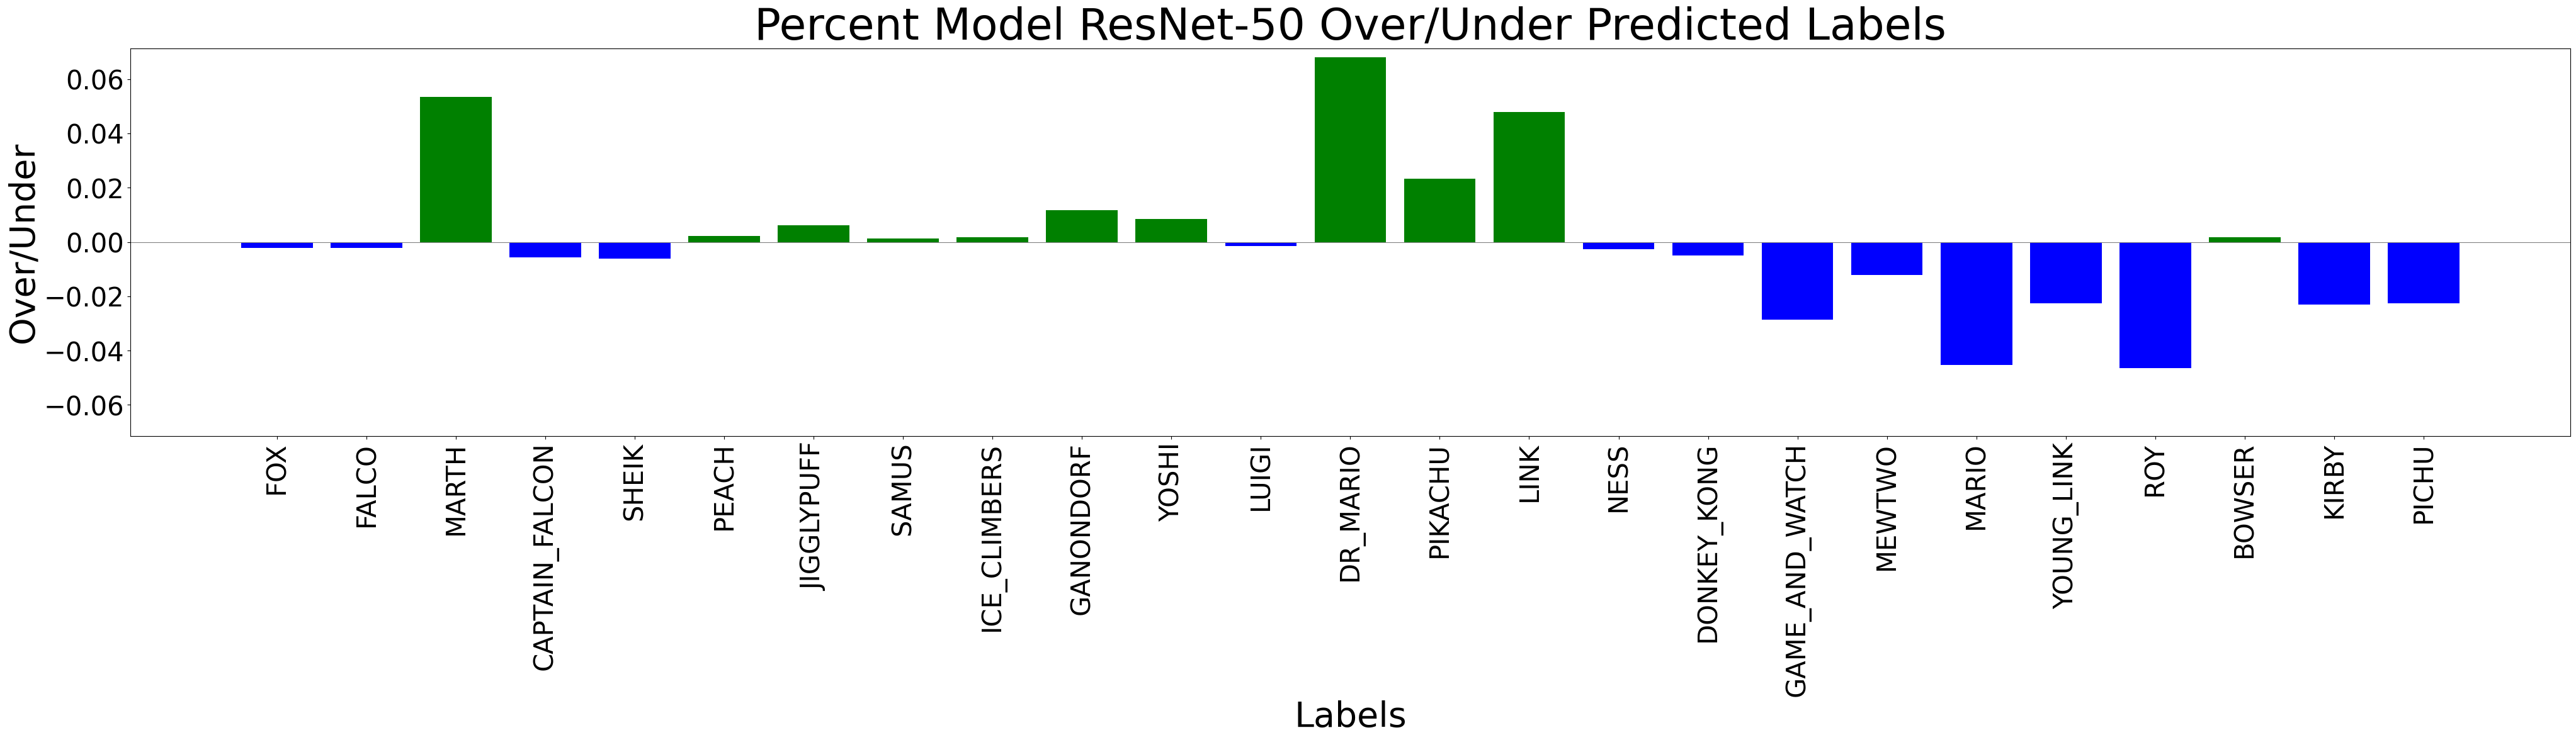

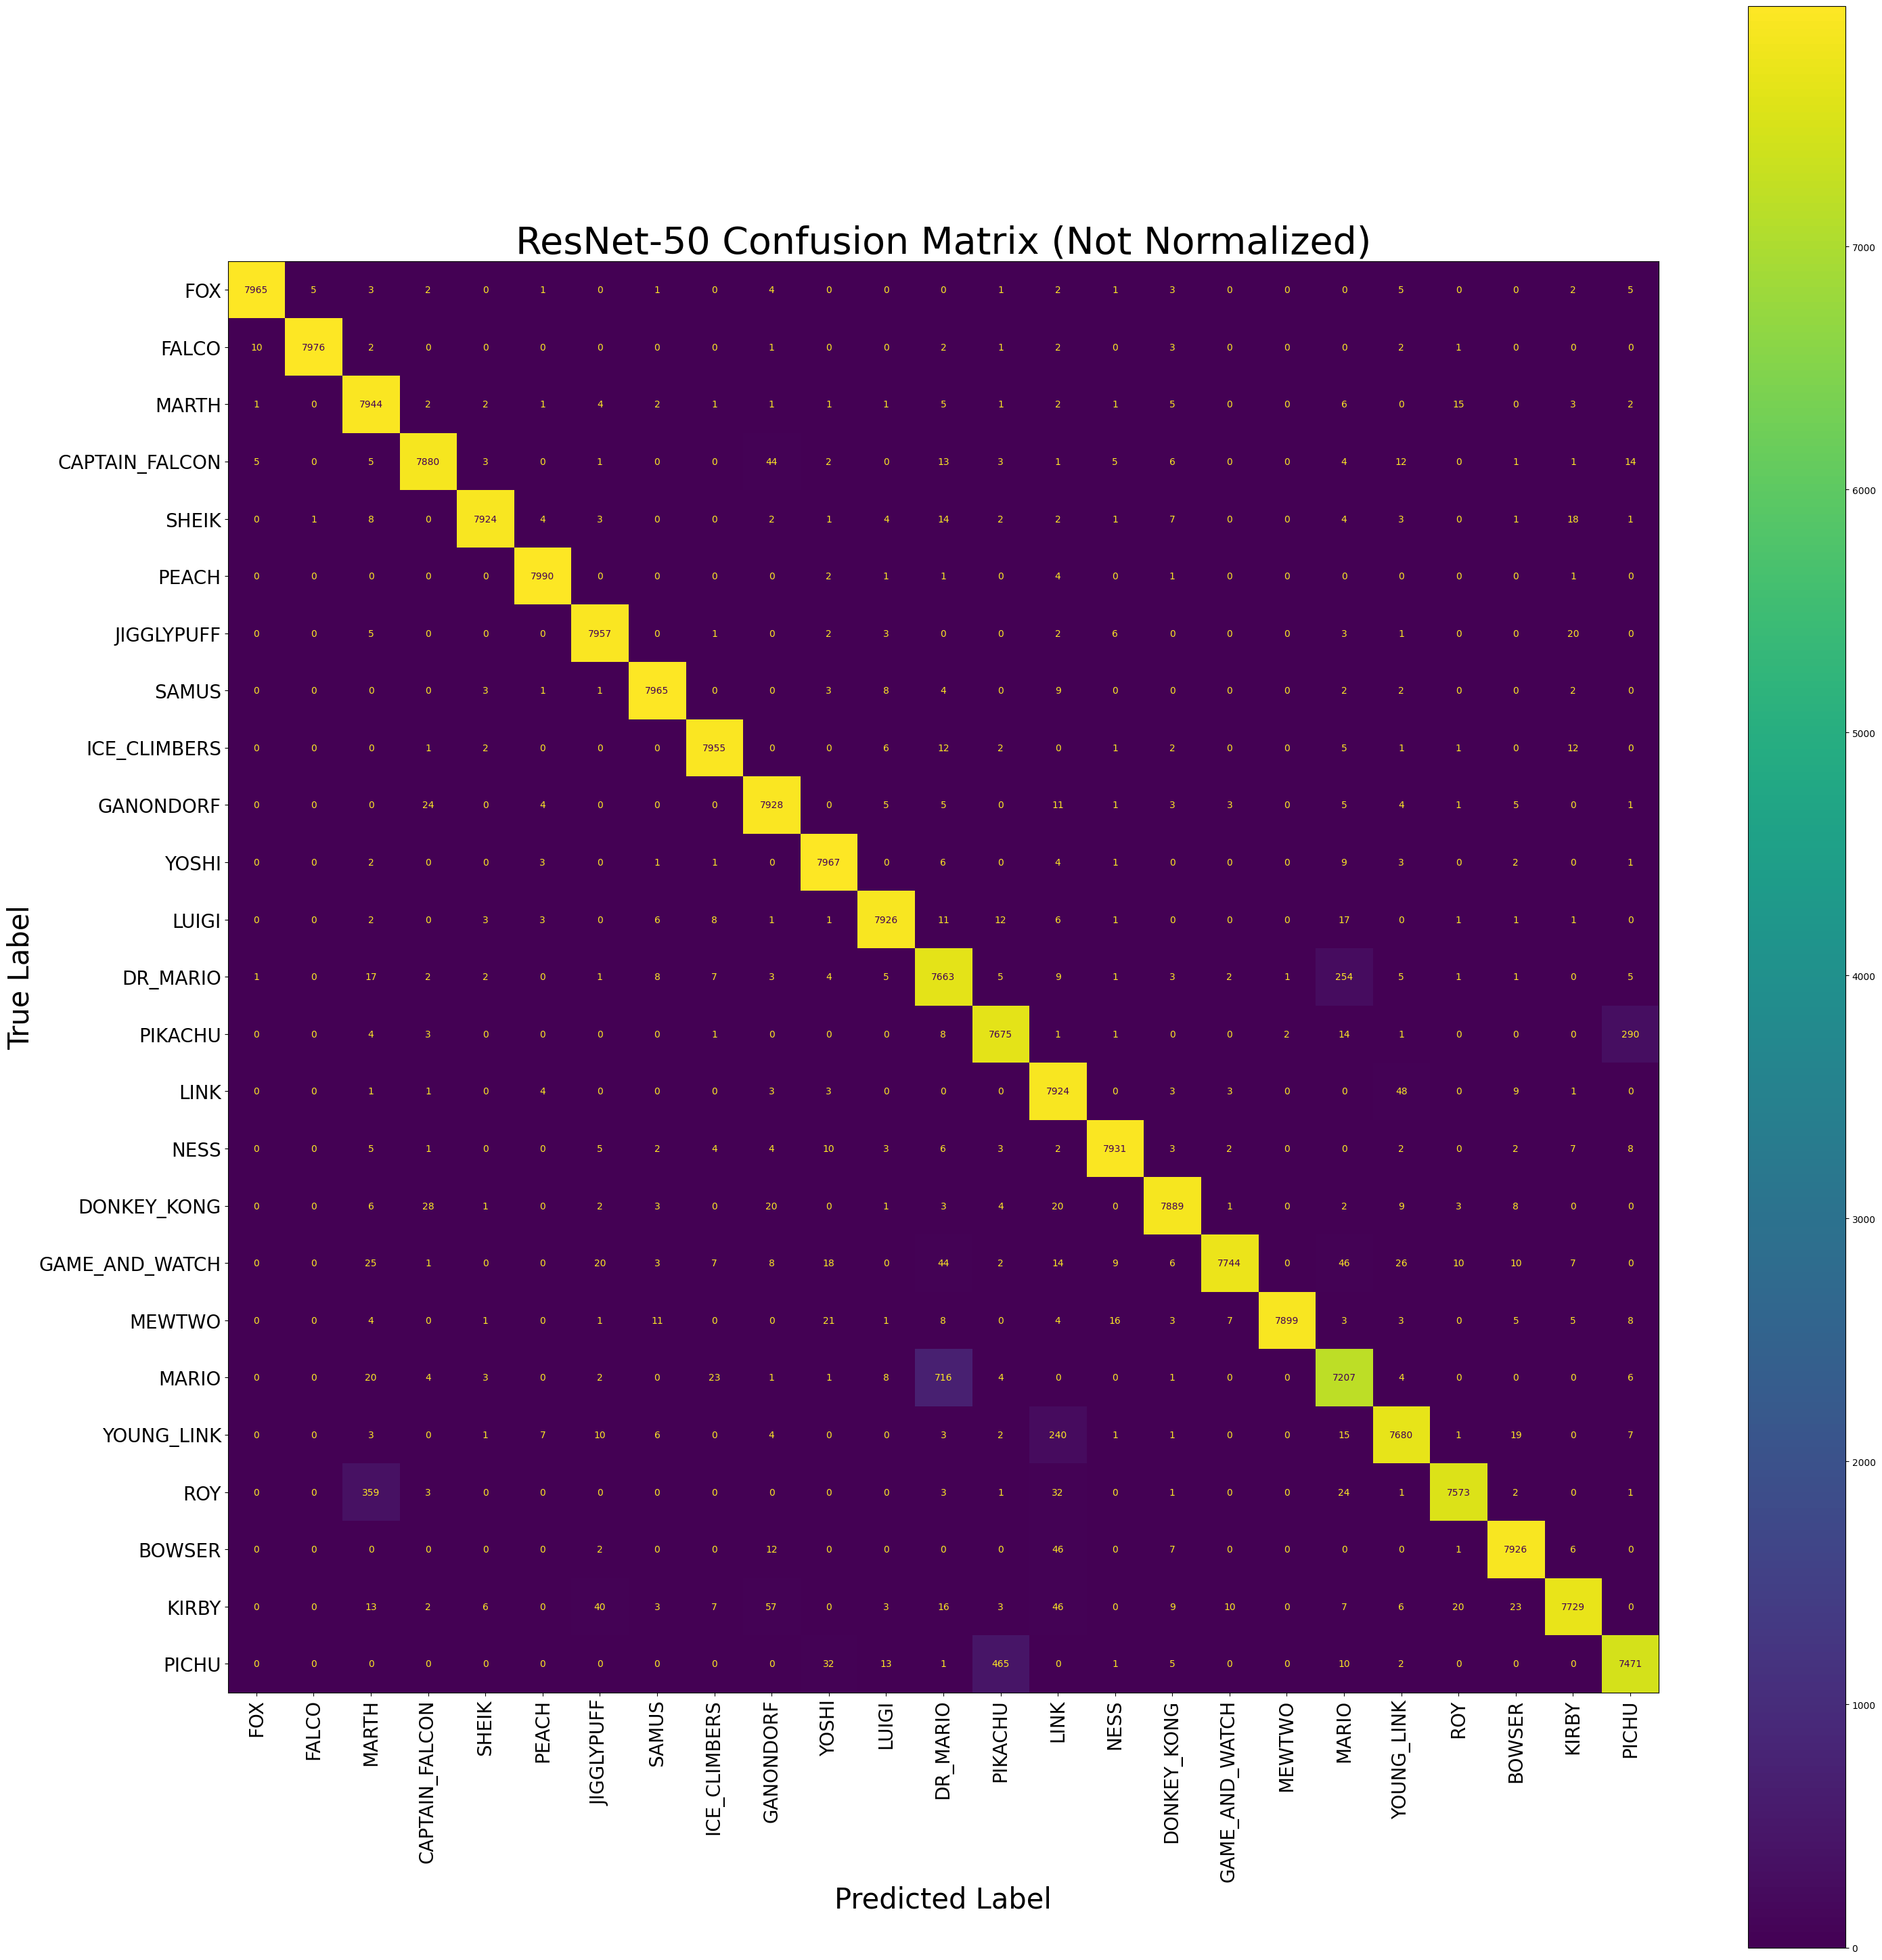

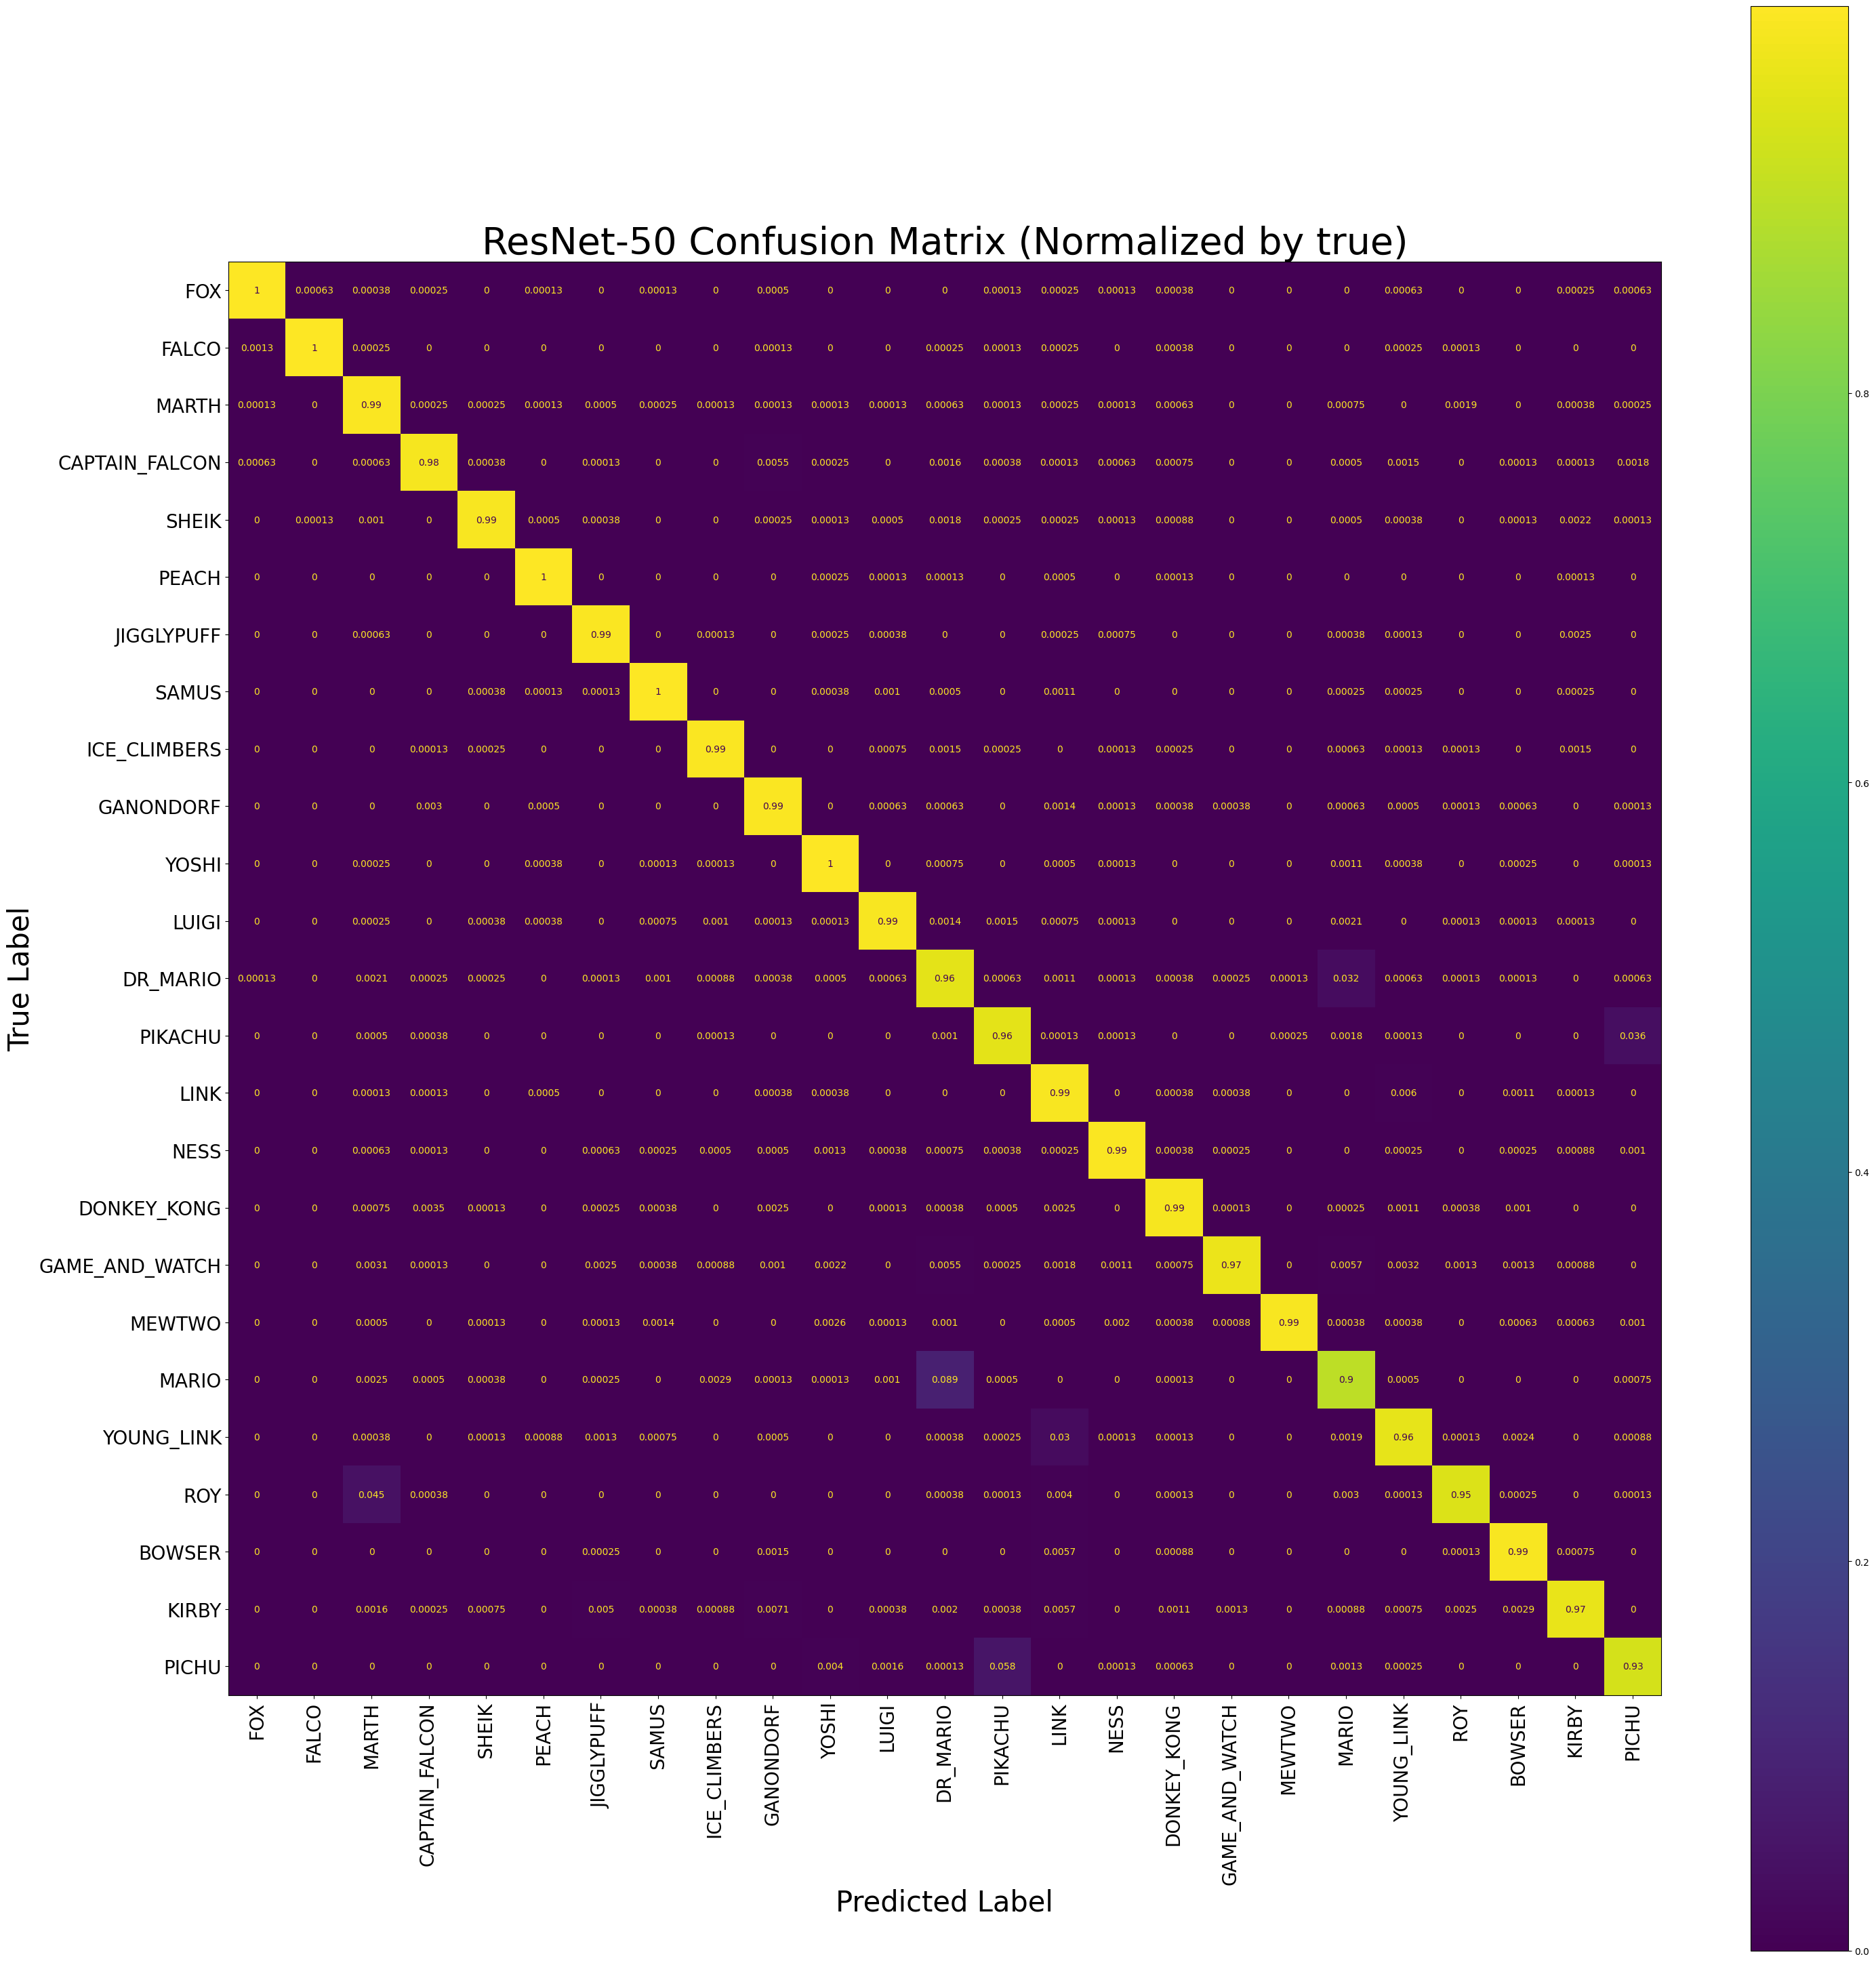

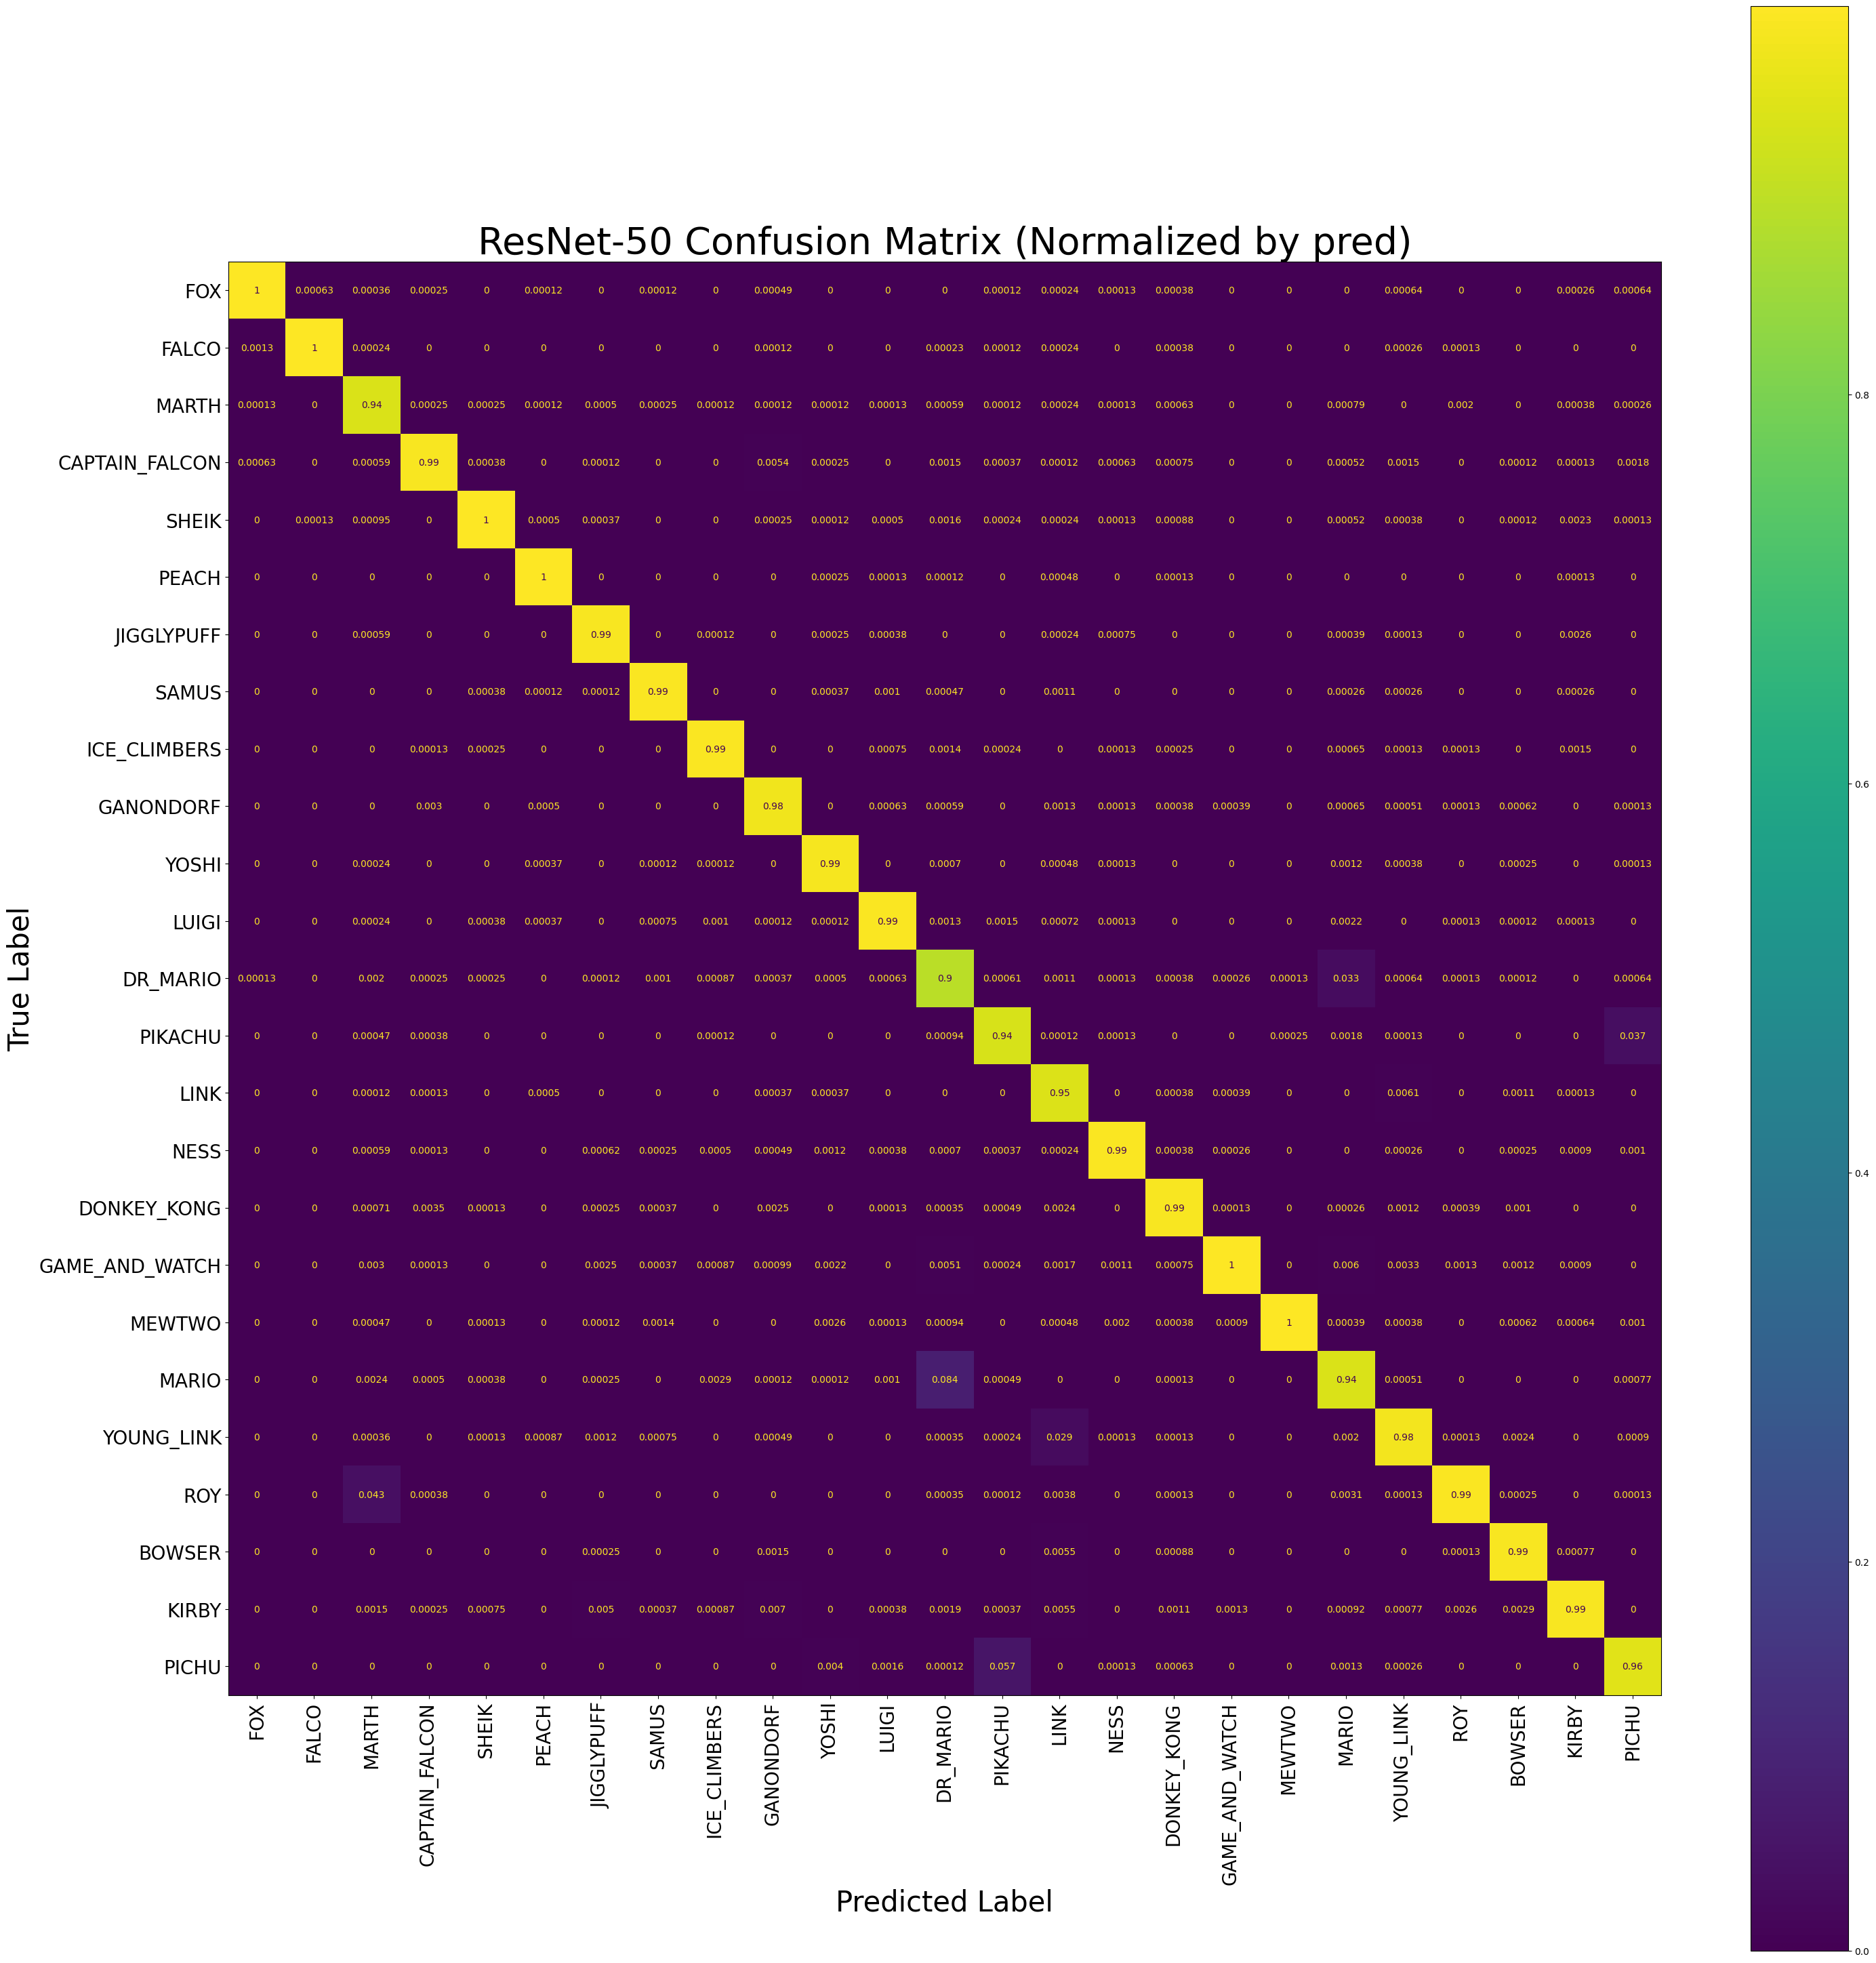

In [ ]:
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)

### Train the Model
We train the model for 6 more epochs, assessing the model's performace every two epochs.

Epoch 2/2: 100%|██████████| 25000/25000 [07:34<00:00, 55.00batch/s, accuracy=99.6, loss=0.0127]



Model: ResNet-50
Accuracy:          0.9806
Cohen Kappa Score: 0.9798

Classification Report:
                precision    recall  f1-score   support

           FOX       1.00      0.99      0.99      8000
         FALCO       0.97      1.00      0.98      8000
         MARTH       0.99      0.99      0.99      8000
CAPTAIN_FALCON       0.94      0.96      0.95      8000
         SHEIK       1.00      1.00      1.00      8000
         PEACH       1.00      1.00      1.00      8000
    JIGGLYPUFF       0.99      0.98      0.99      8000
         SAMUS       0.99      0.99      0.99      8000
  ICE_CLIMBERS       0.99      1.00      0.99      8000
     GANONDORF       0.99      1.00      0.99      8000
         YOSHI       0.99      0.97      0.98      8000
         LUIGI       0.99      0.98      0.98      8000
      DR_MARIO       0.99      0.99      0.99      8000
       PIKACHU       0.97      0.93      0.95      8000
          LINK       0.97      0.99      0.98      8000
         

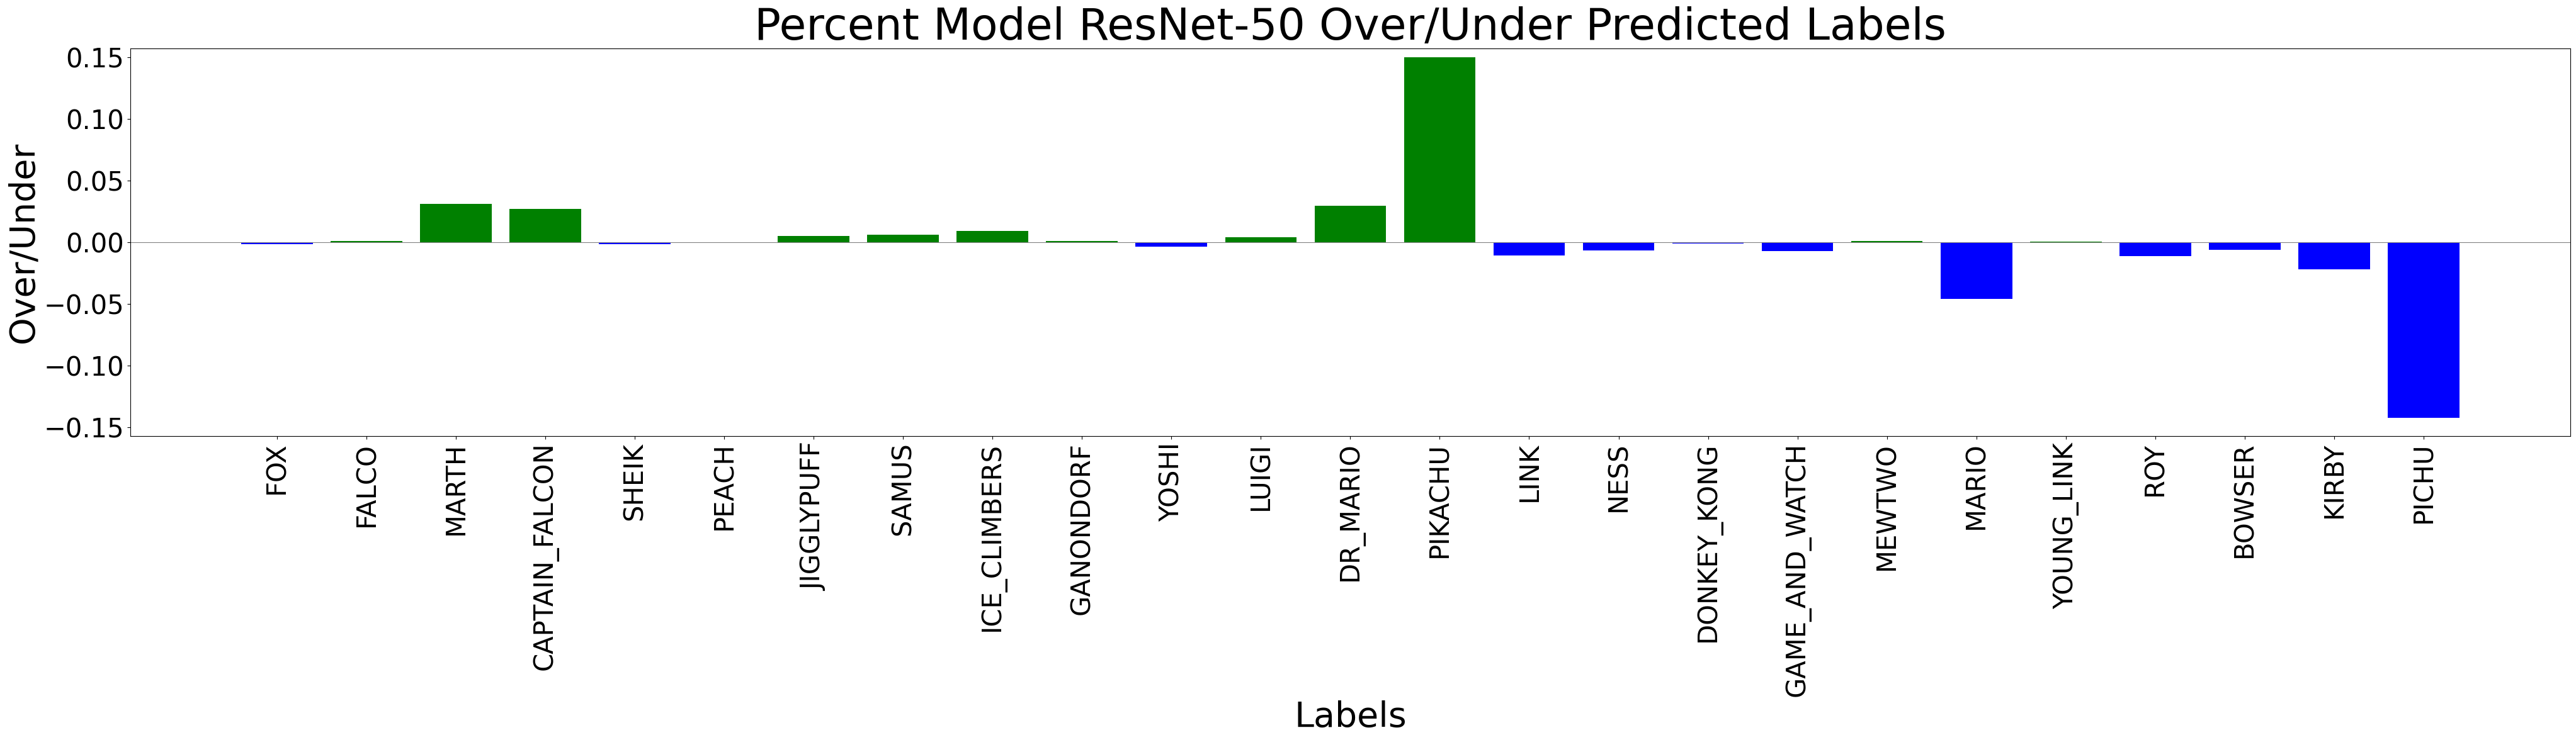

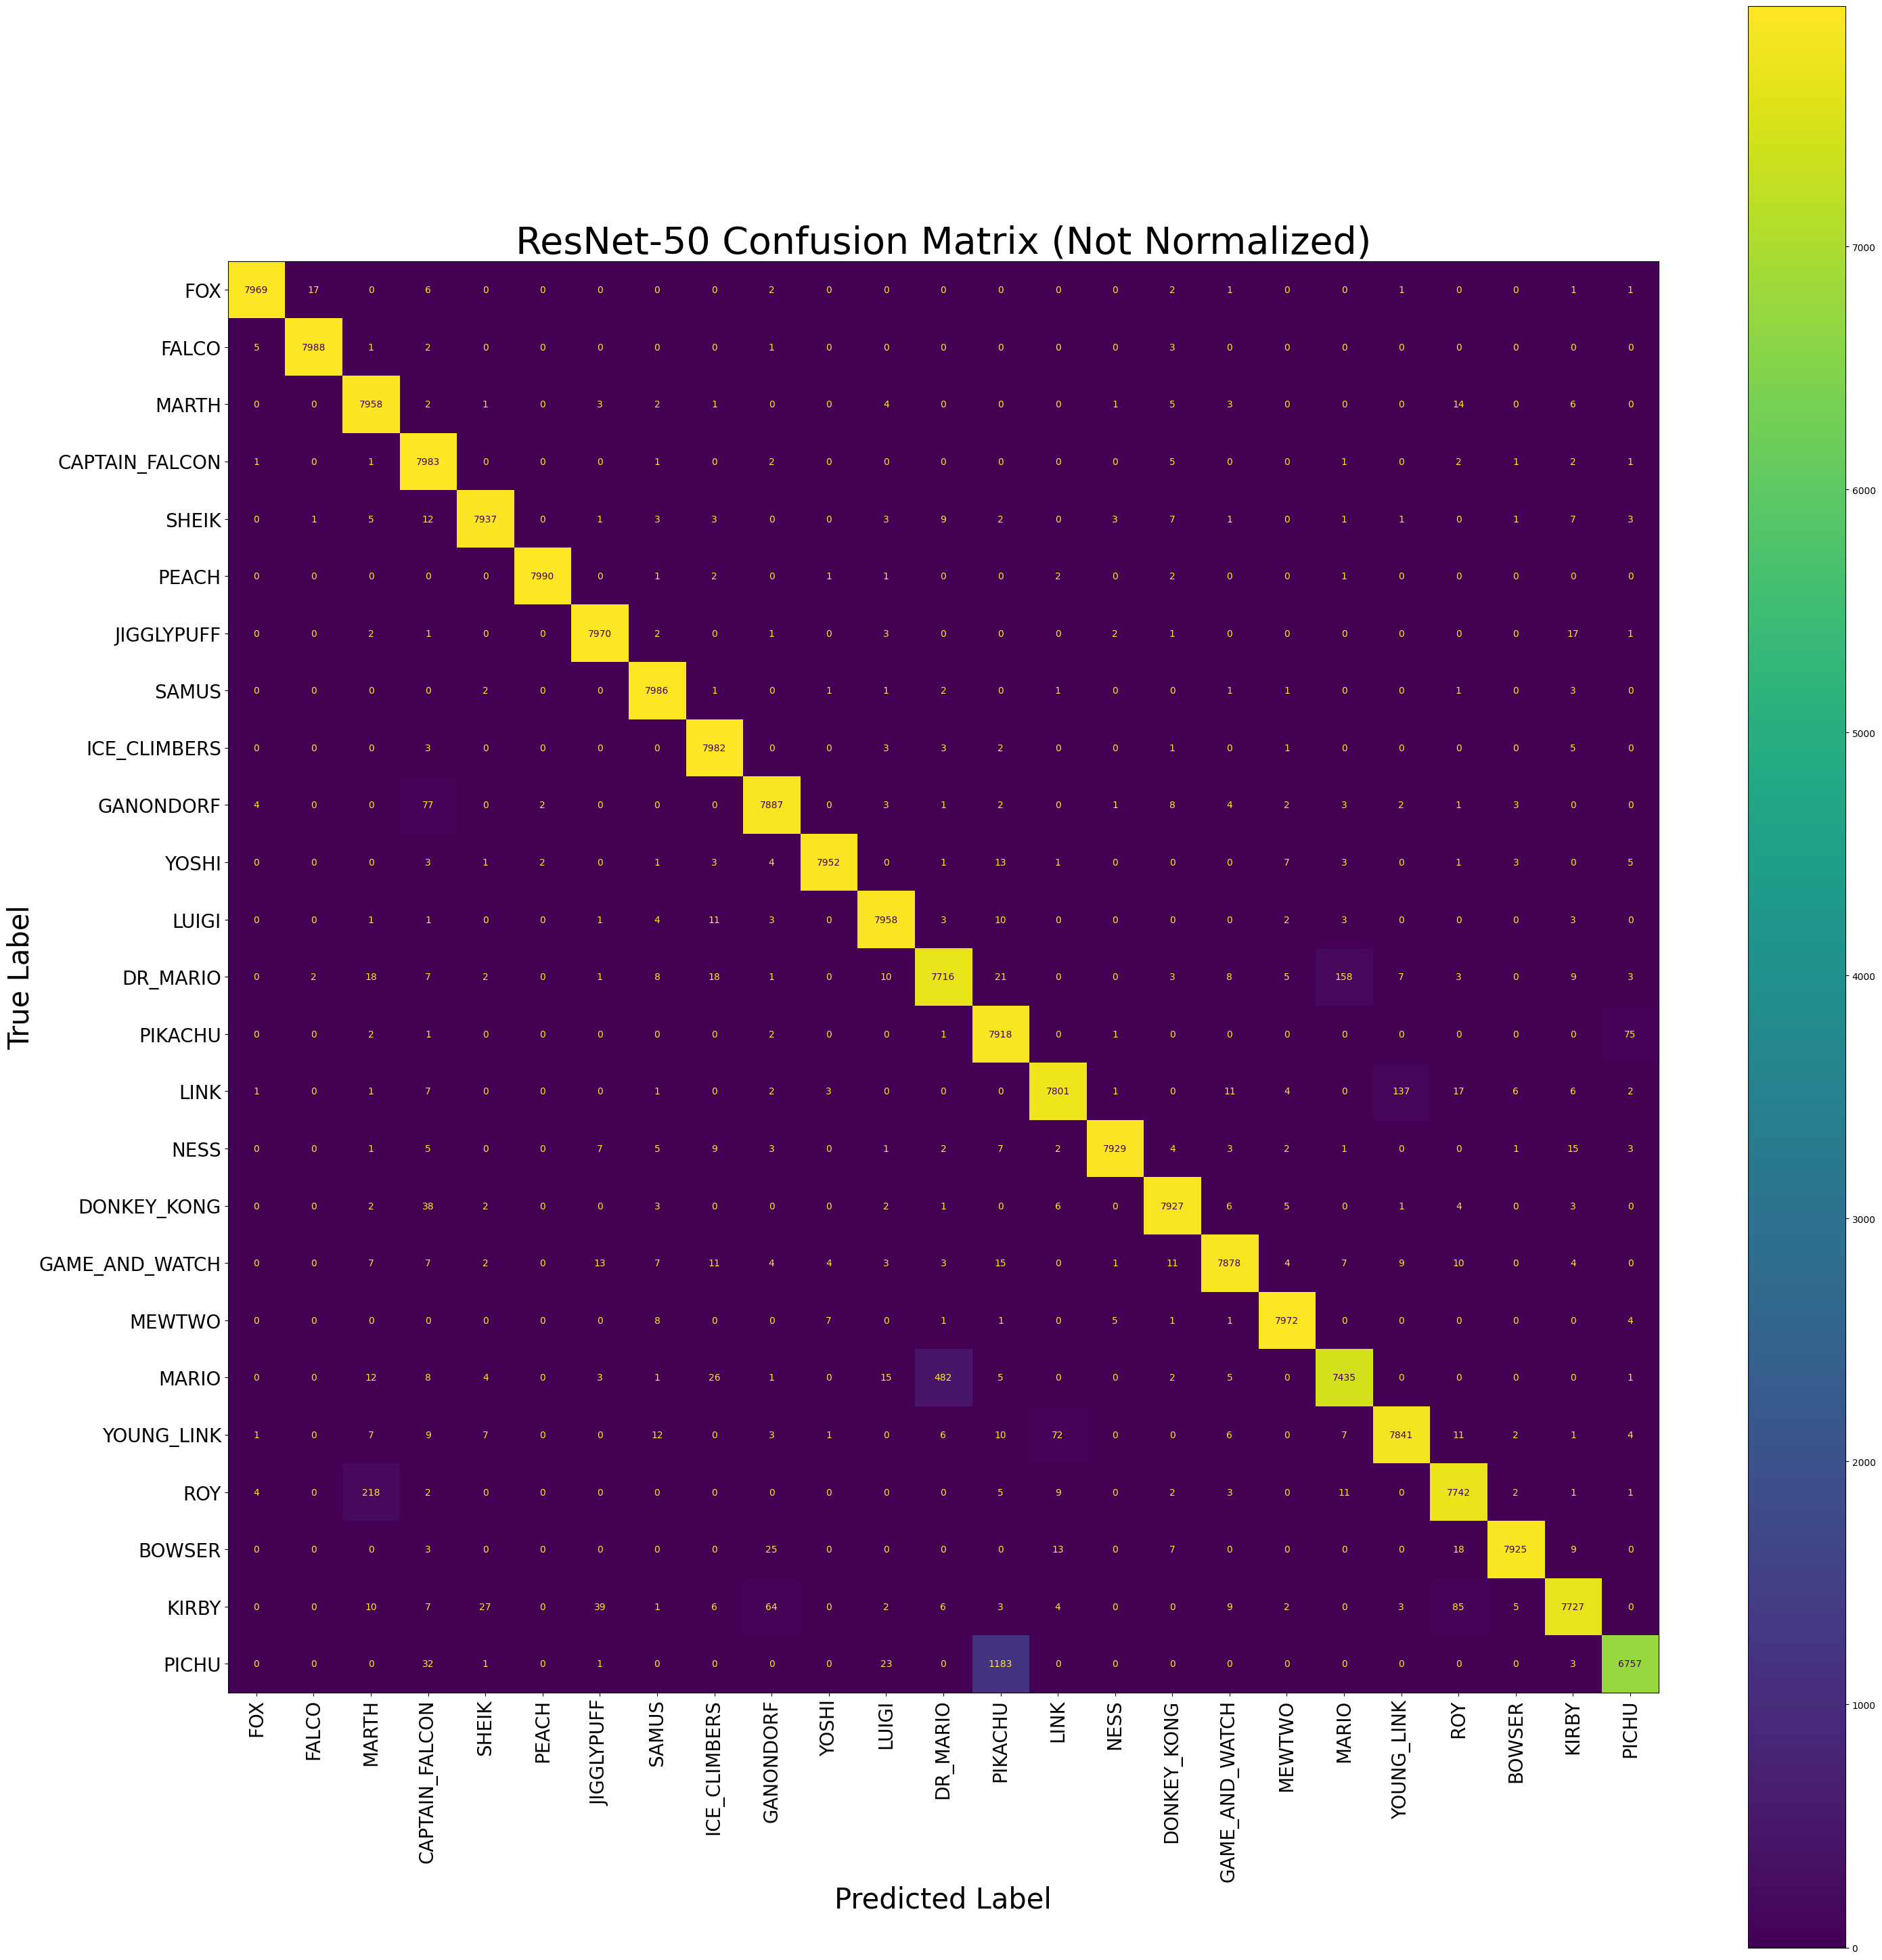

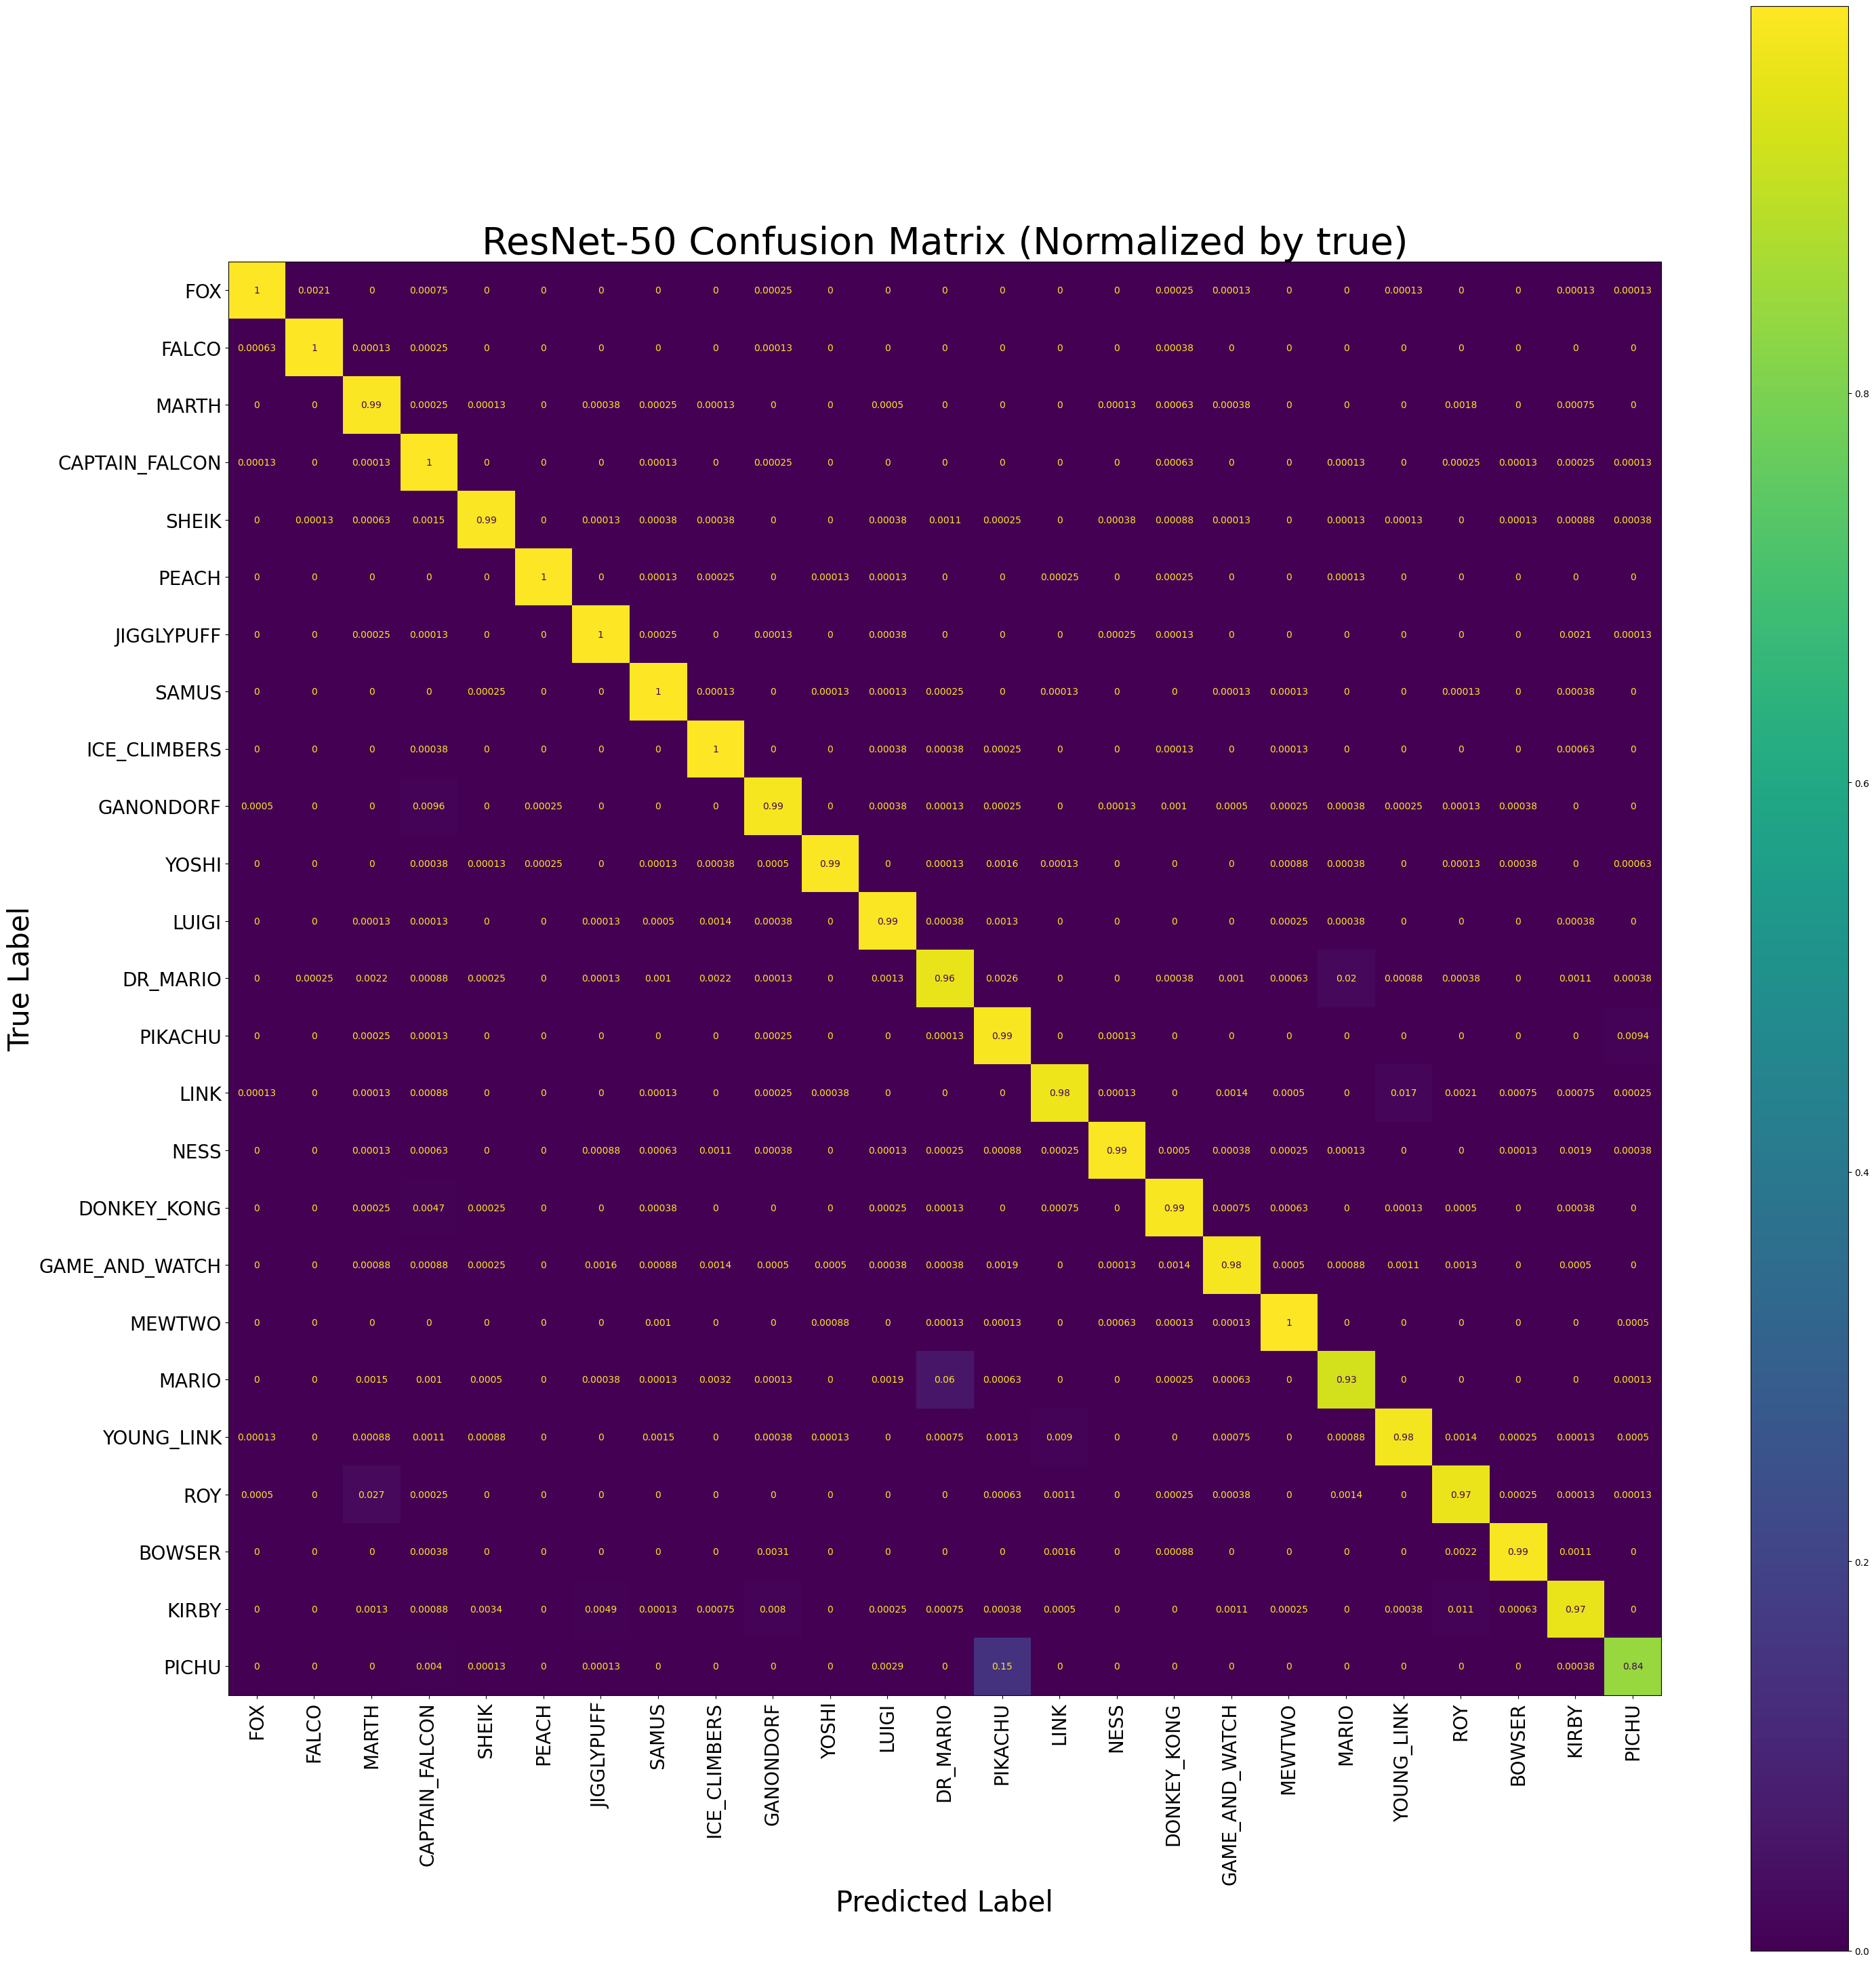

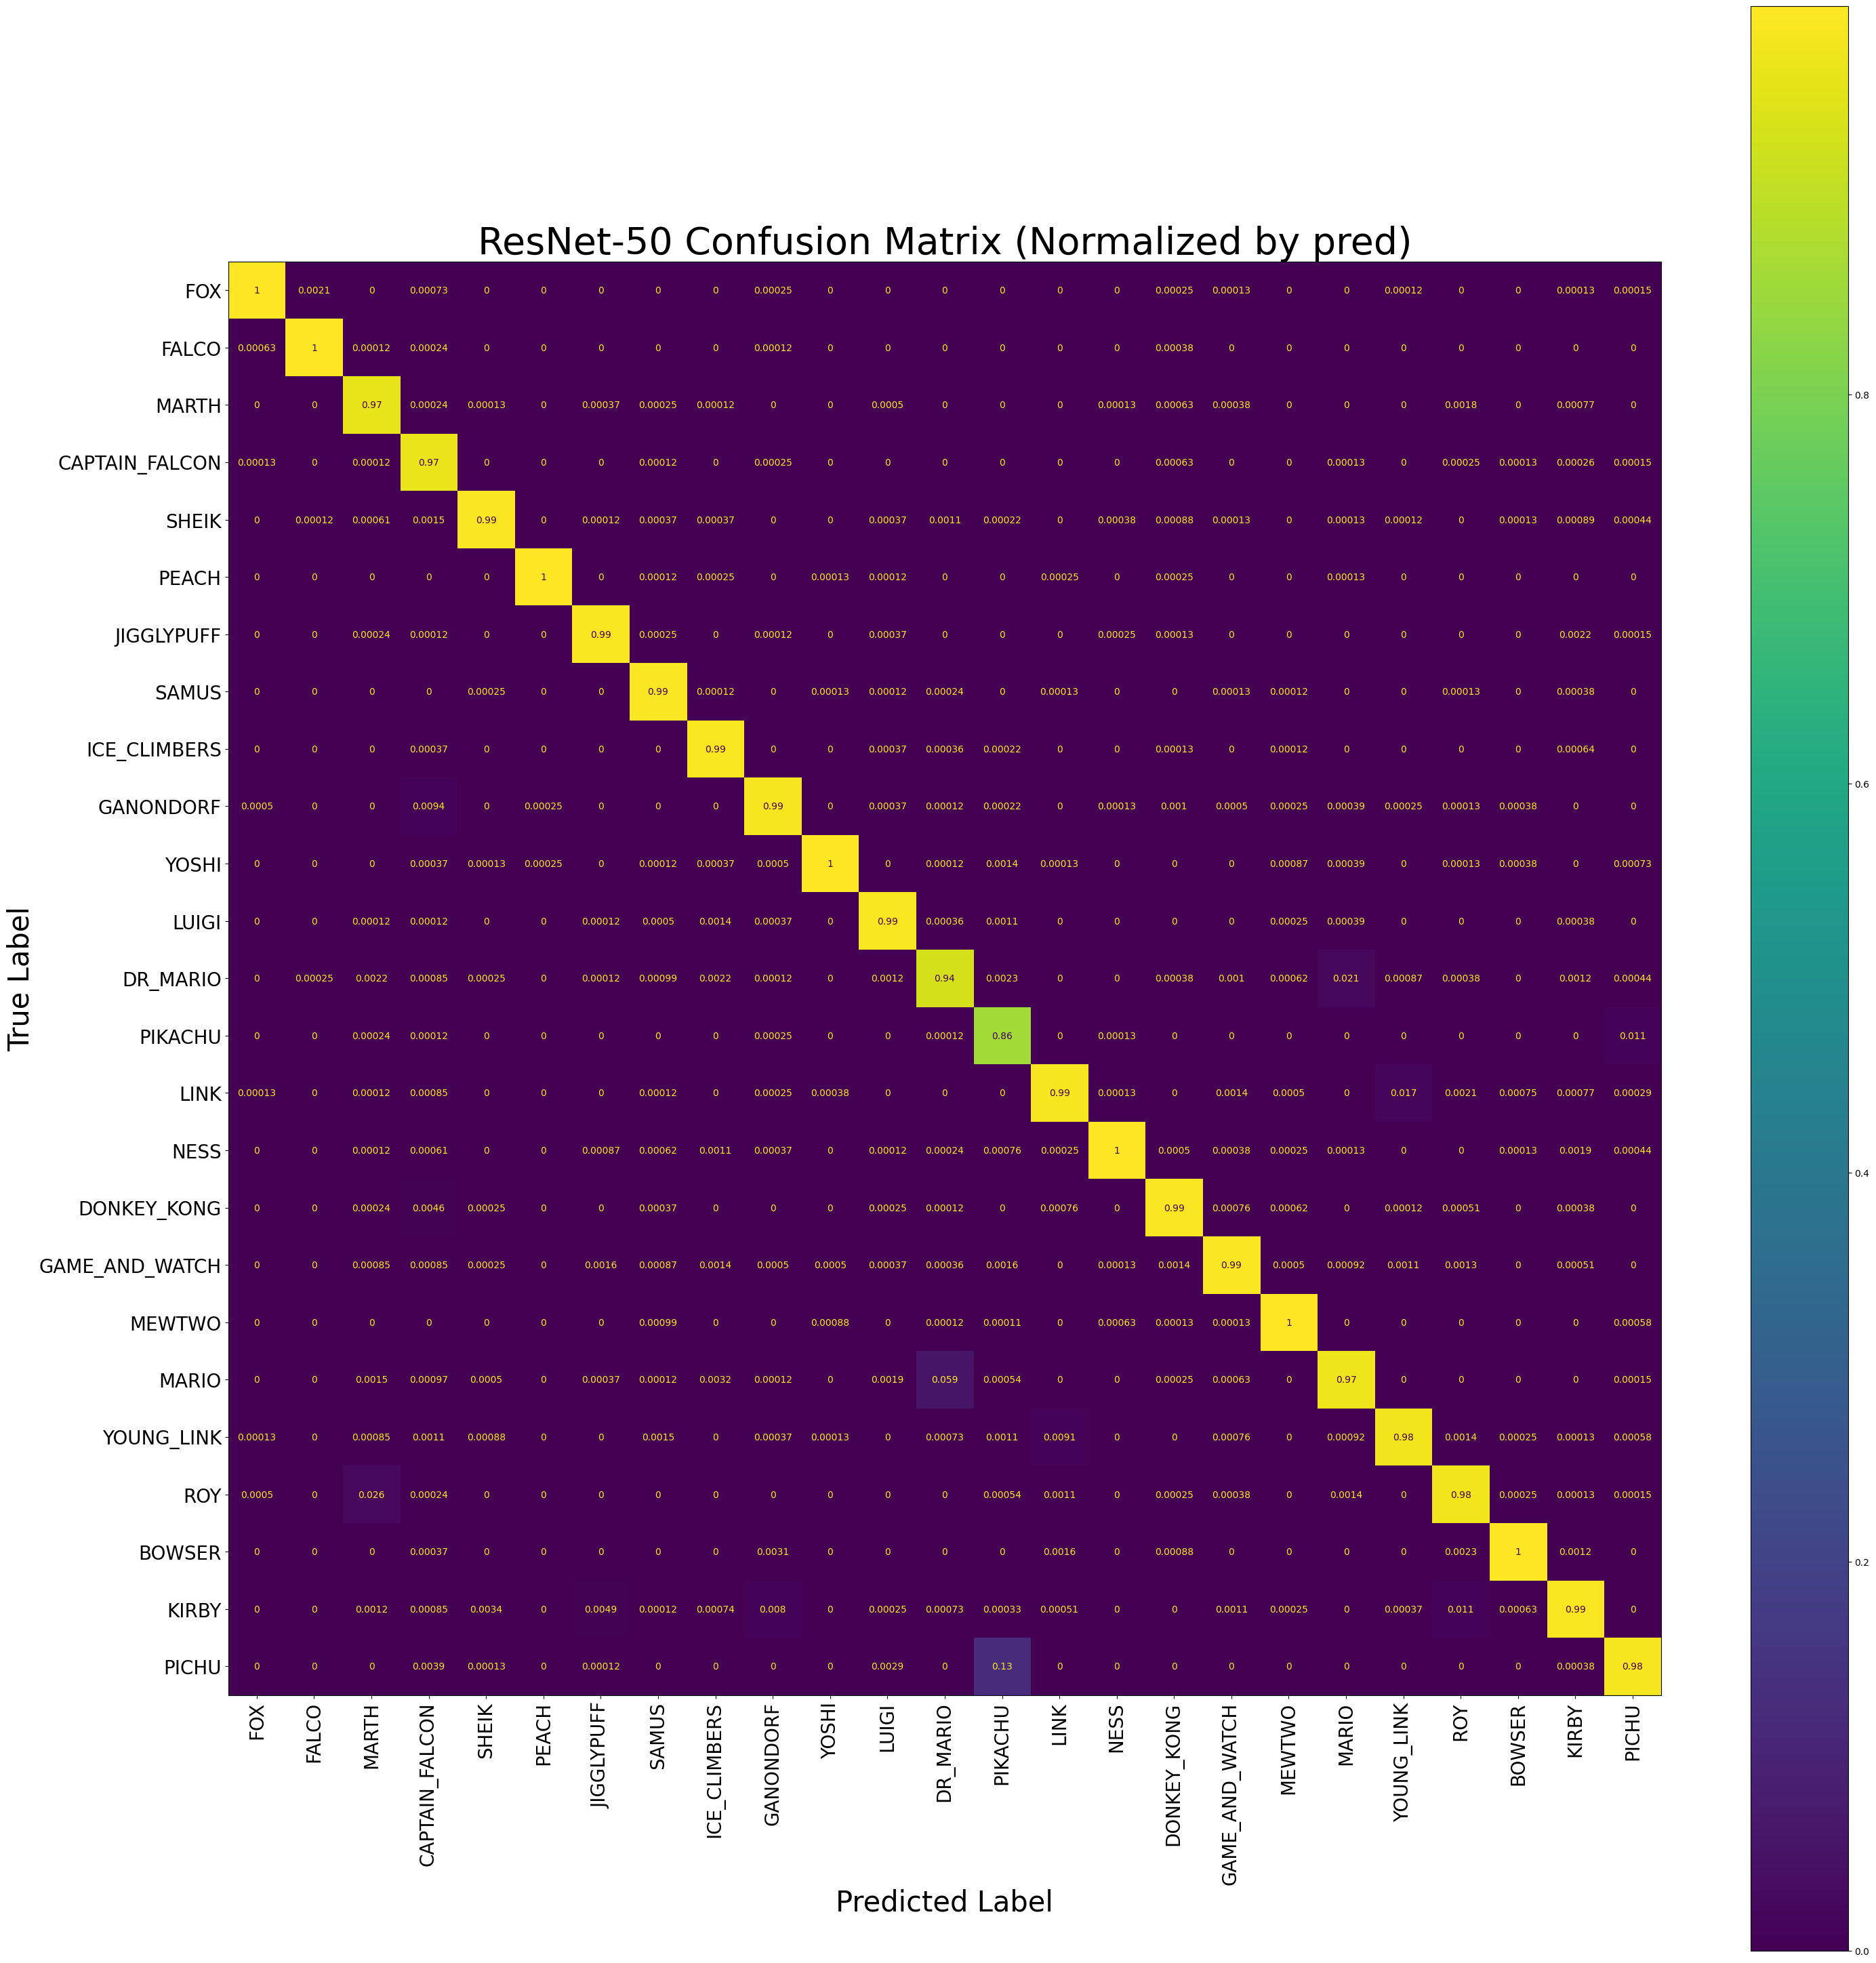

In [93]:
slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)

Epoch 2/2: 100%|██████████| 25000/25000 [08:12<00:00, 50.77batch/s, accuracy=99.7, loss=0.00893]



Model: ResNet-50
Accuracy:          0.9837
Cohen Kappa Score: 0.9830

Classification Report:
                precision    recall  f1-score   support

           FOX       0.99      0.99      0.99      8000
         FALCO       0.99      0.99      0.99      8000
         MARTH       0.99      1.00      0.99      8000
CAPTAIN_FALCON       0.91      0.97      0.94      8000
         SHEIK       1.00      1.00      1.00      8000
         PEACH       1.00      1.00      1.00      8000
    JIGGLYPUFF       0.99      0.99      0.99      8000
         SAMUS       0.99      0.99      0.99      8000
  ICE_CLIMBERS       1.00      1.00      1.00      8000
     GANONDORF       0.99      1.00      1.00      8000
         YOSHI       1.00      0.97      0.98      8000
         LUIGI       0.98      0.99      0.98      8000
      DR_MARIO       0.99      1.00      1.00      8000
       PIKACHU       0.98      0.91      0.94      8000
          LINK       0.98      0.99      0.99      8000
         

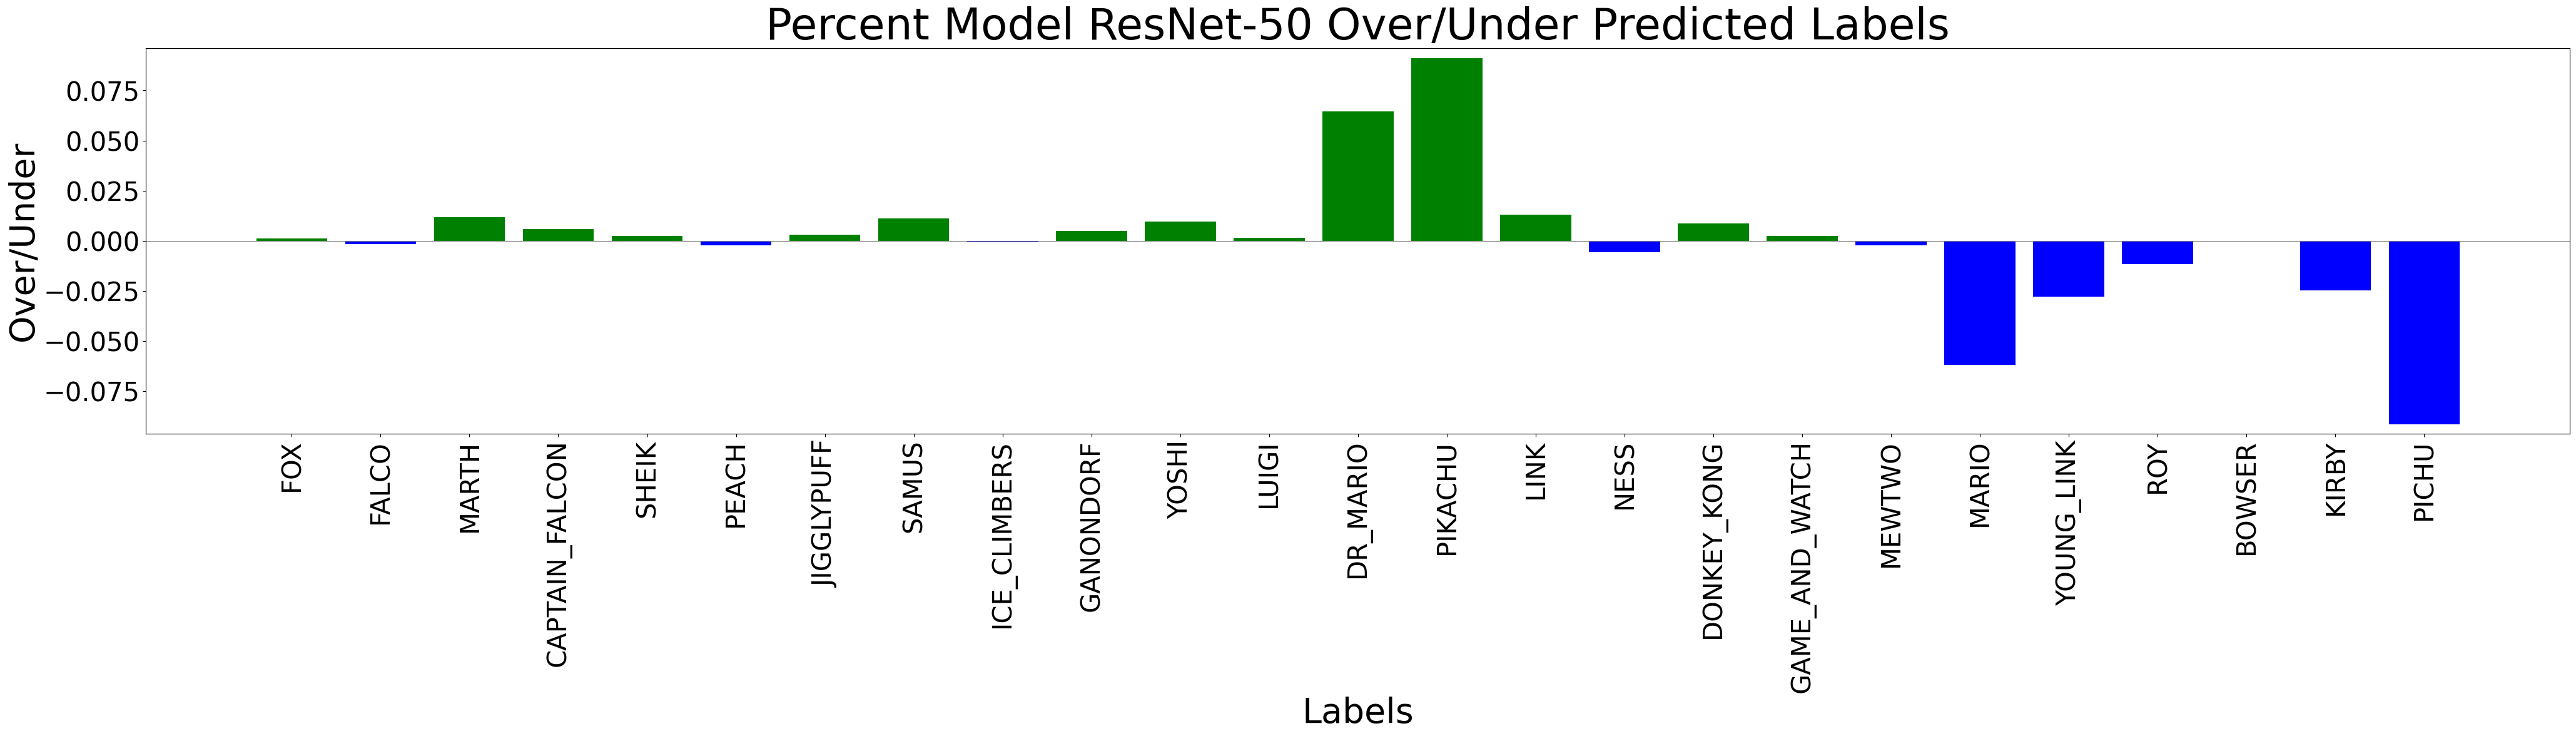

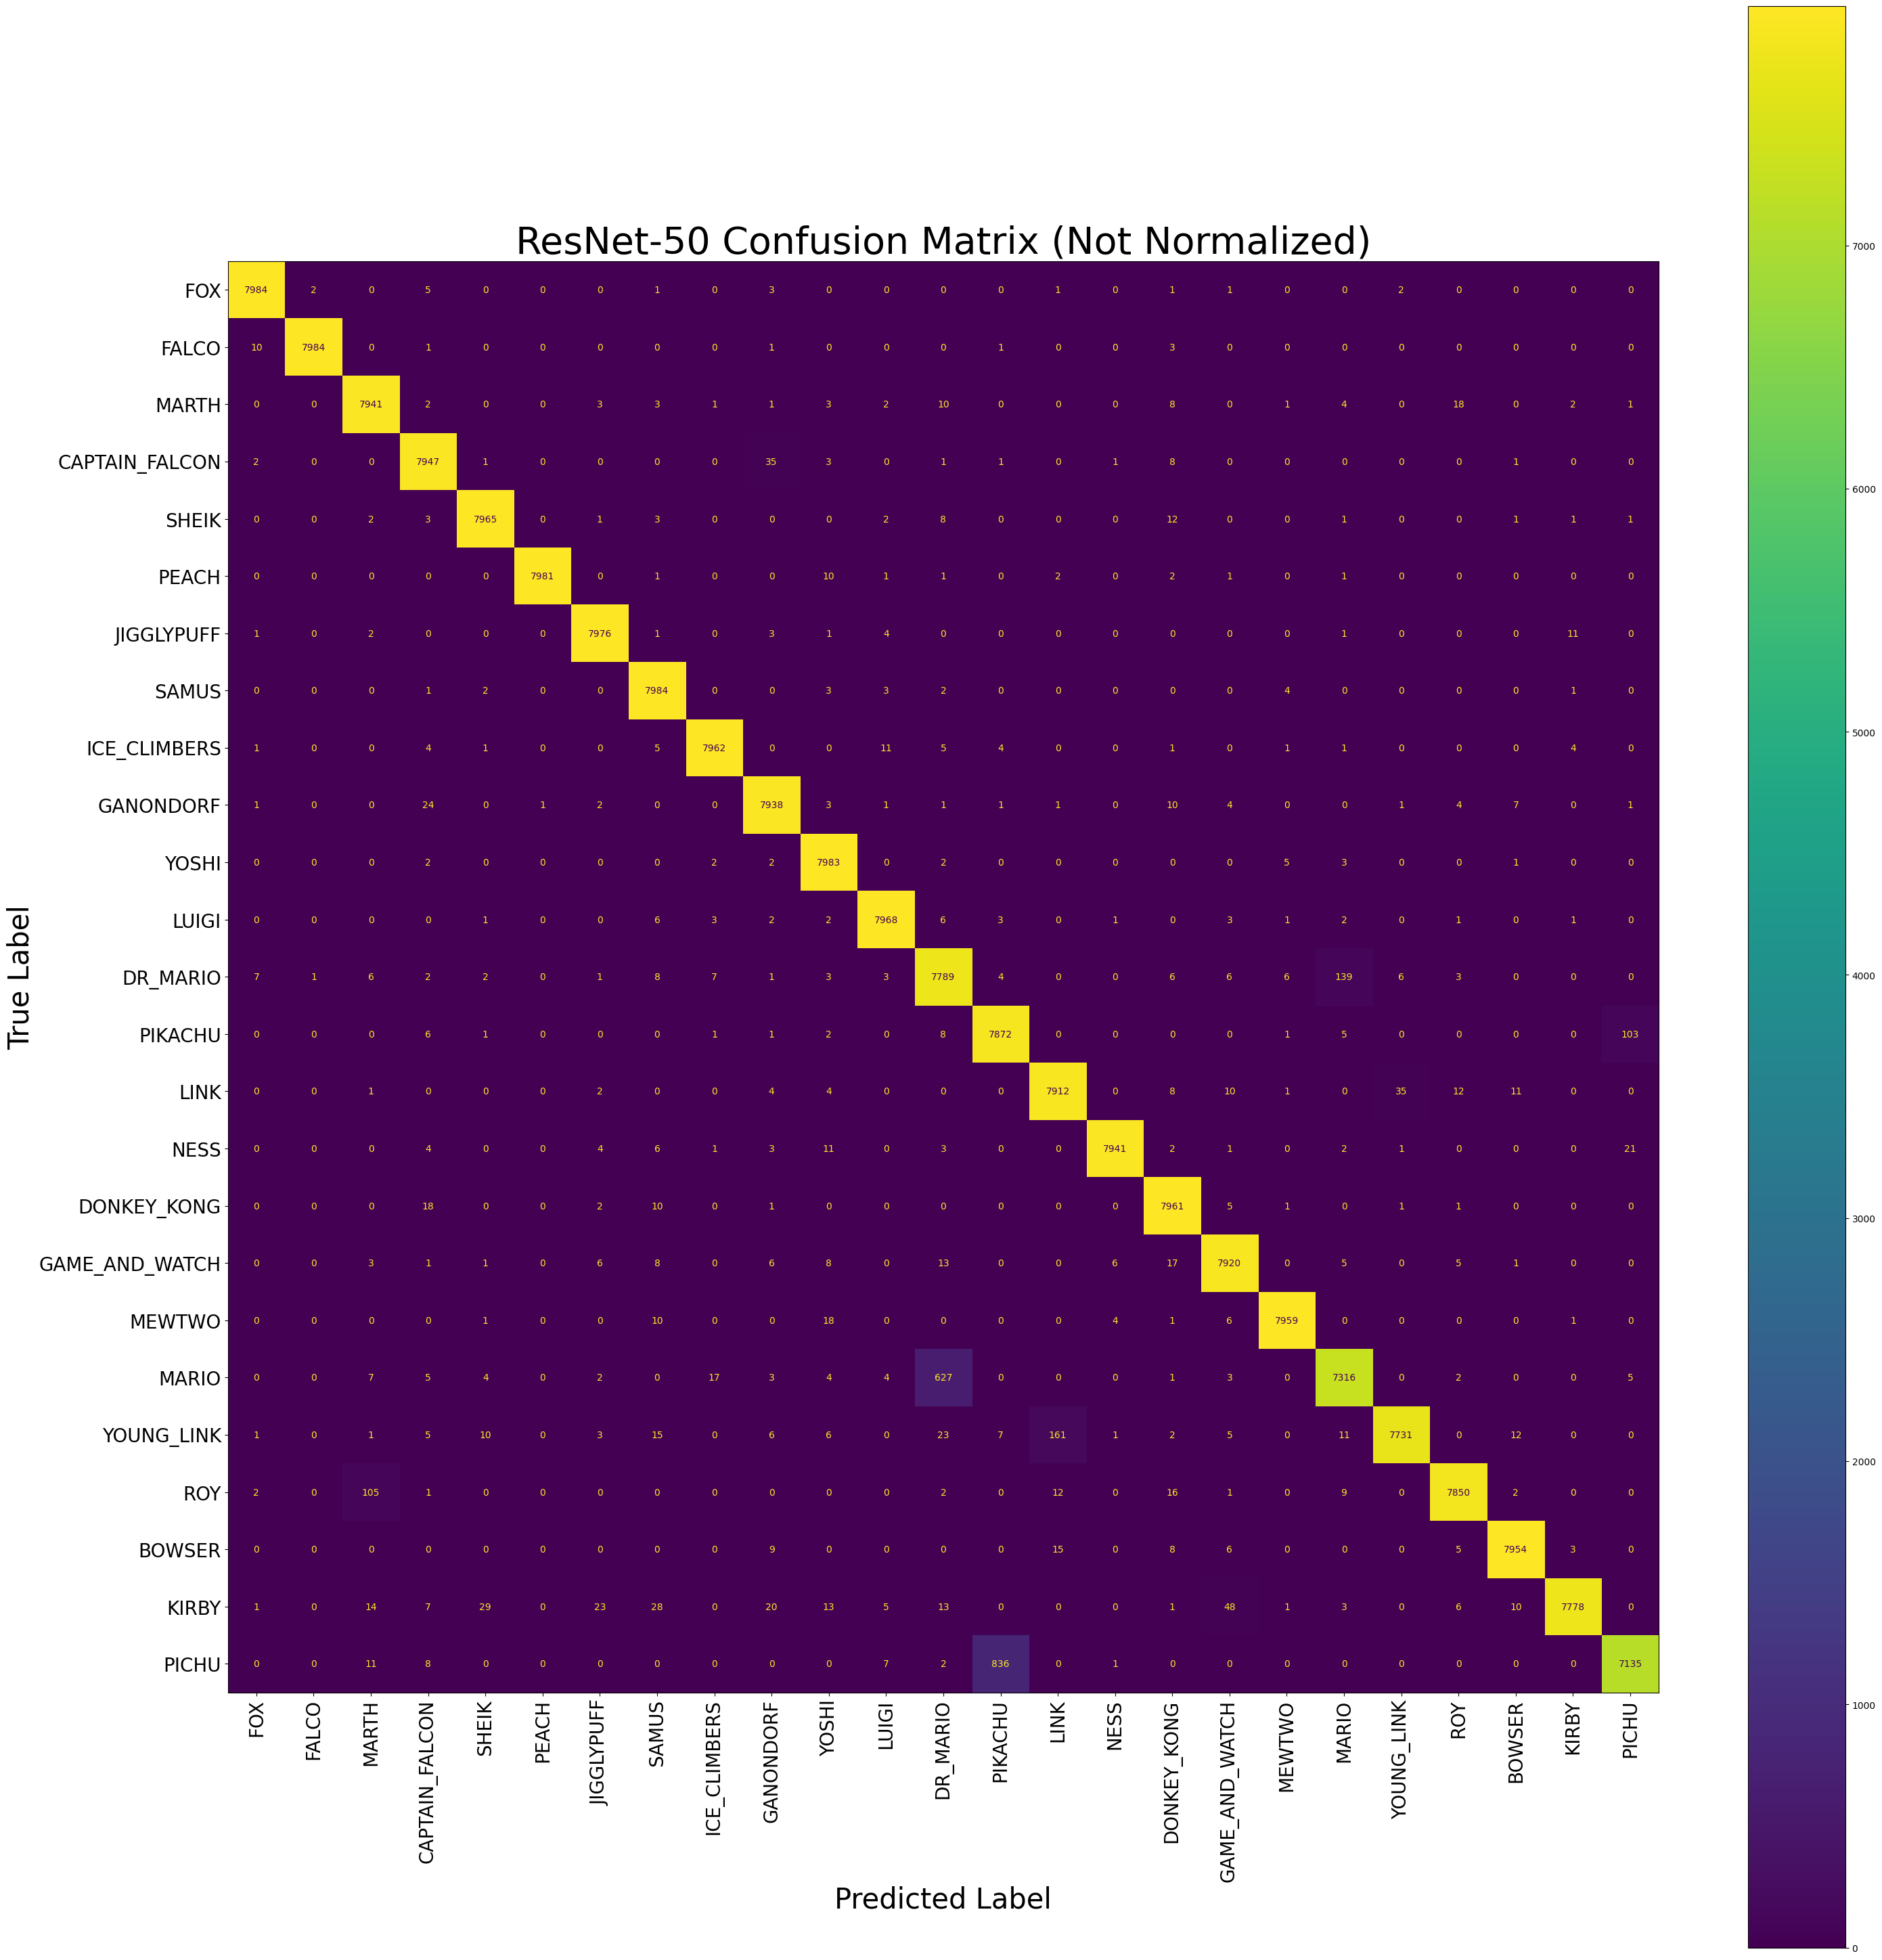

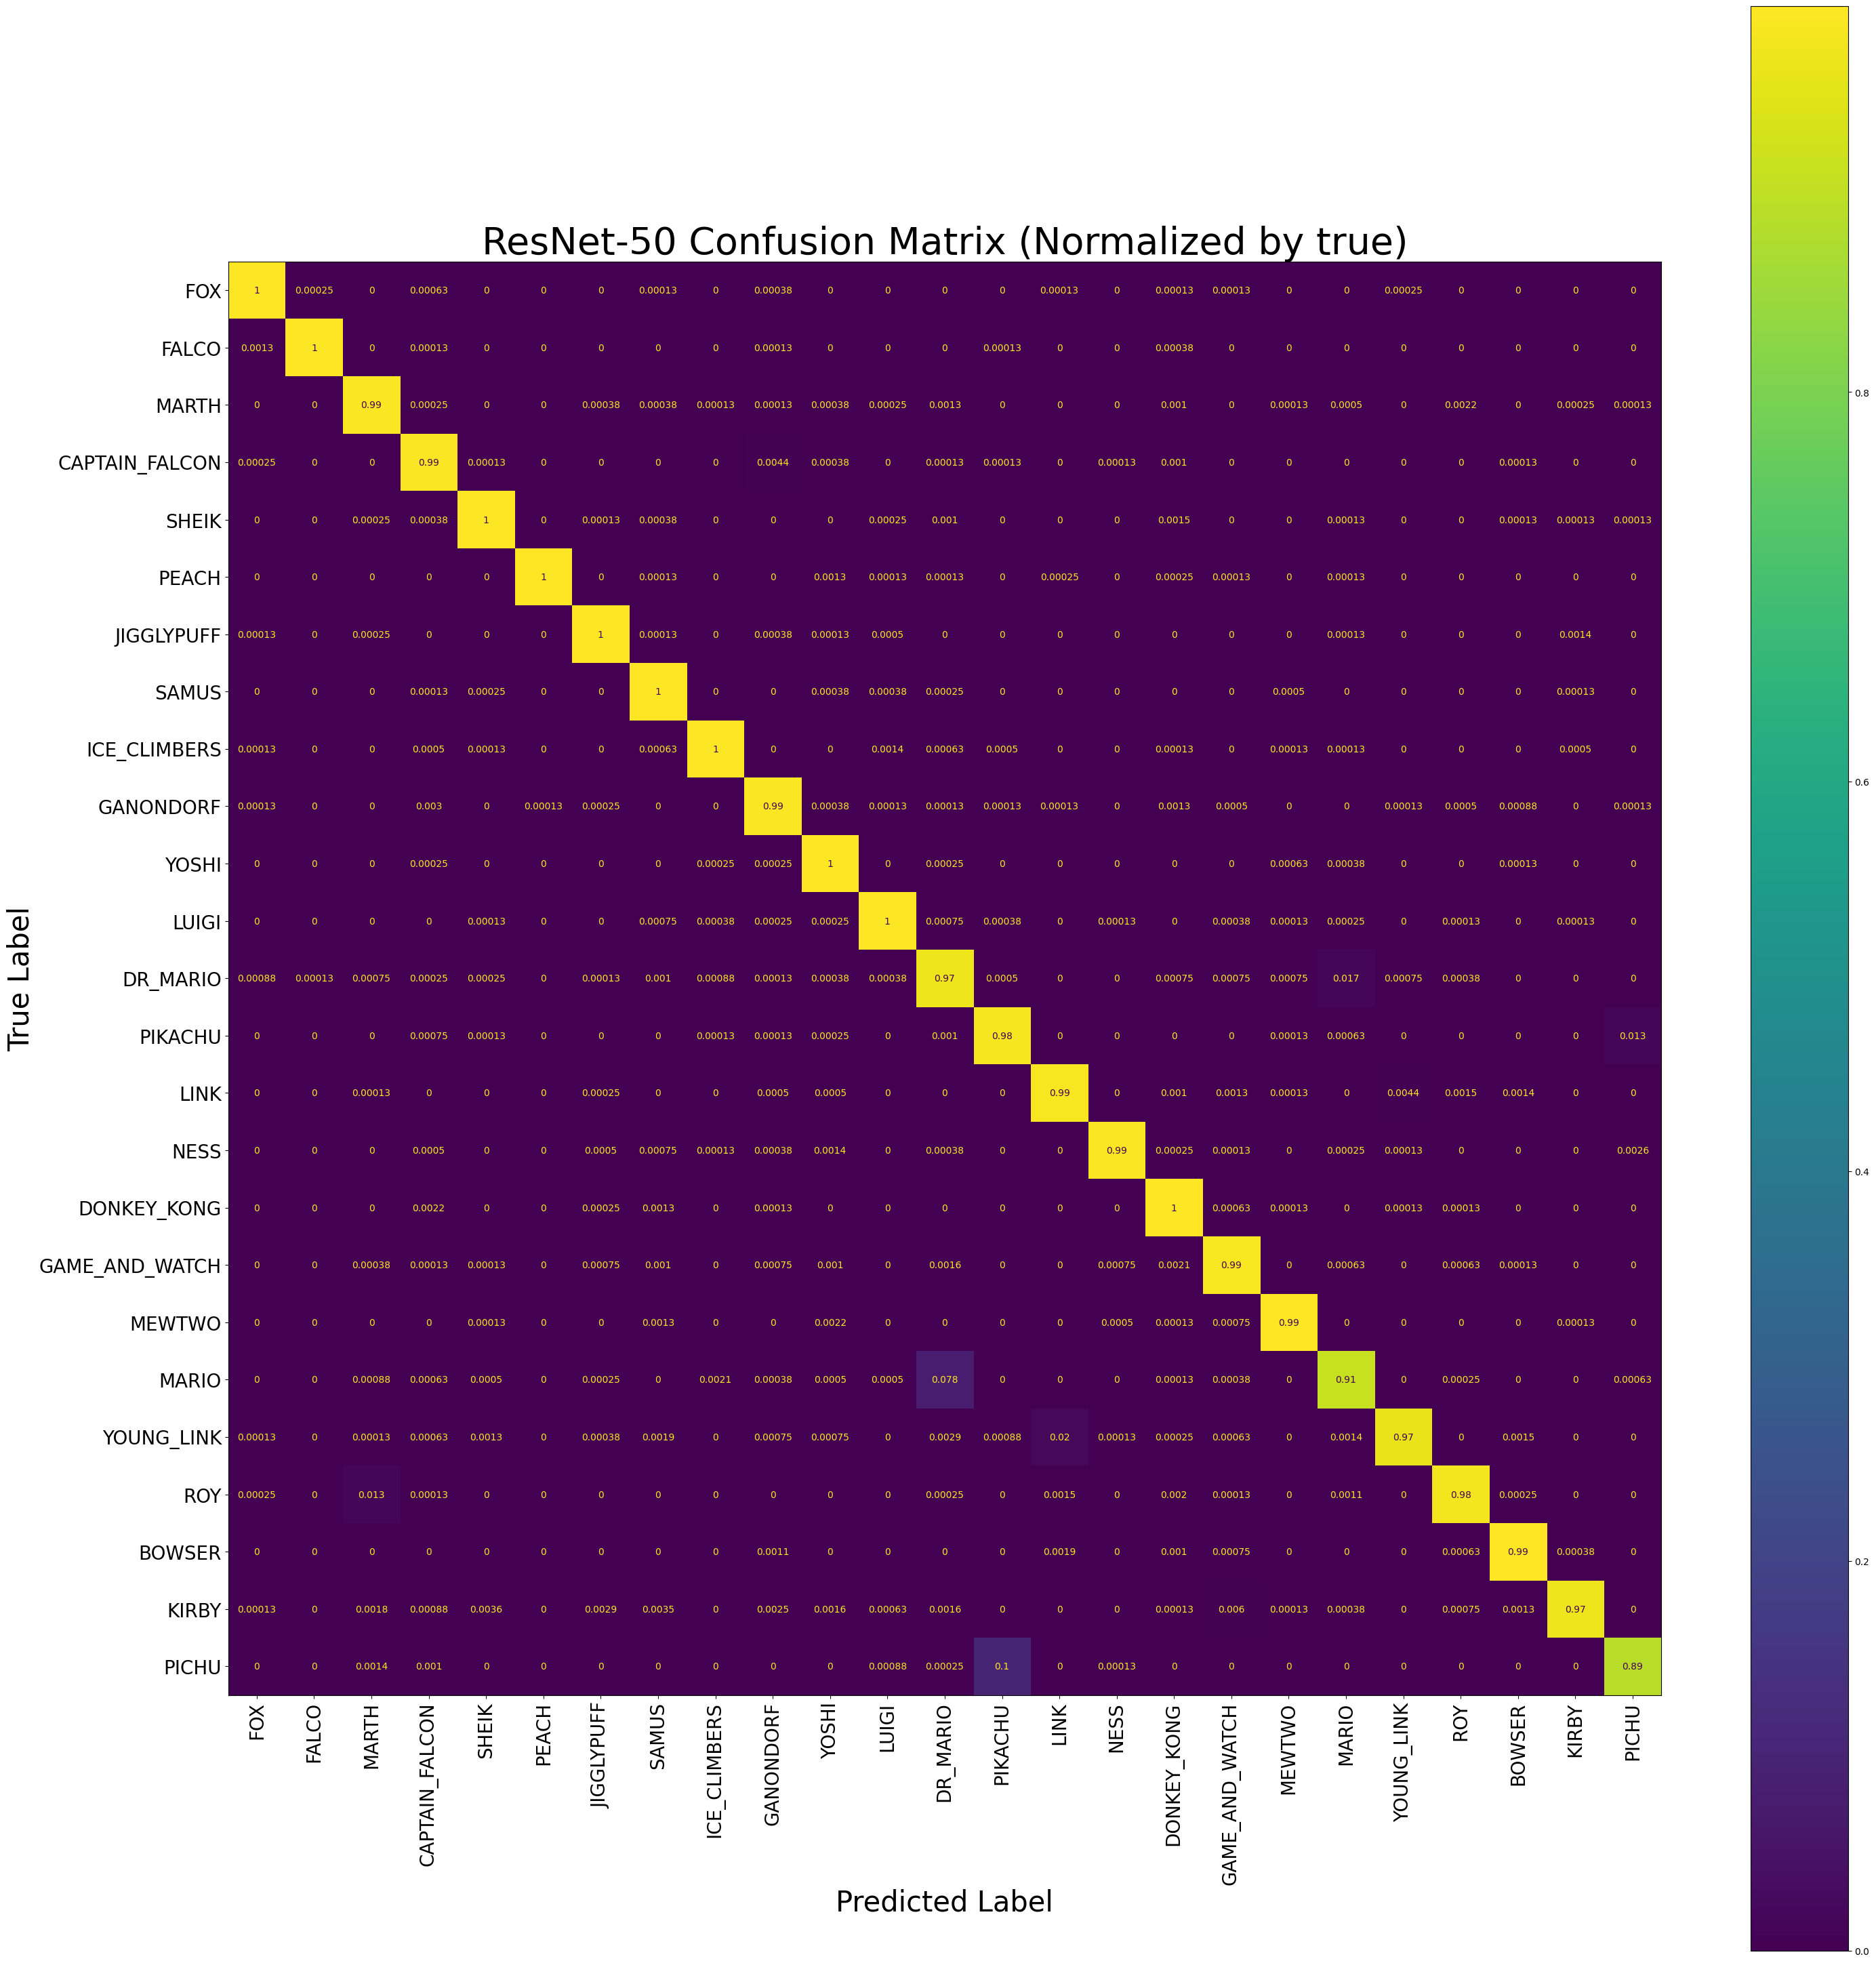

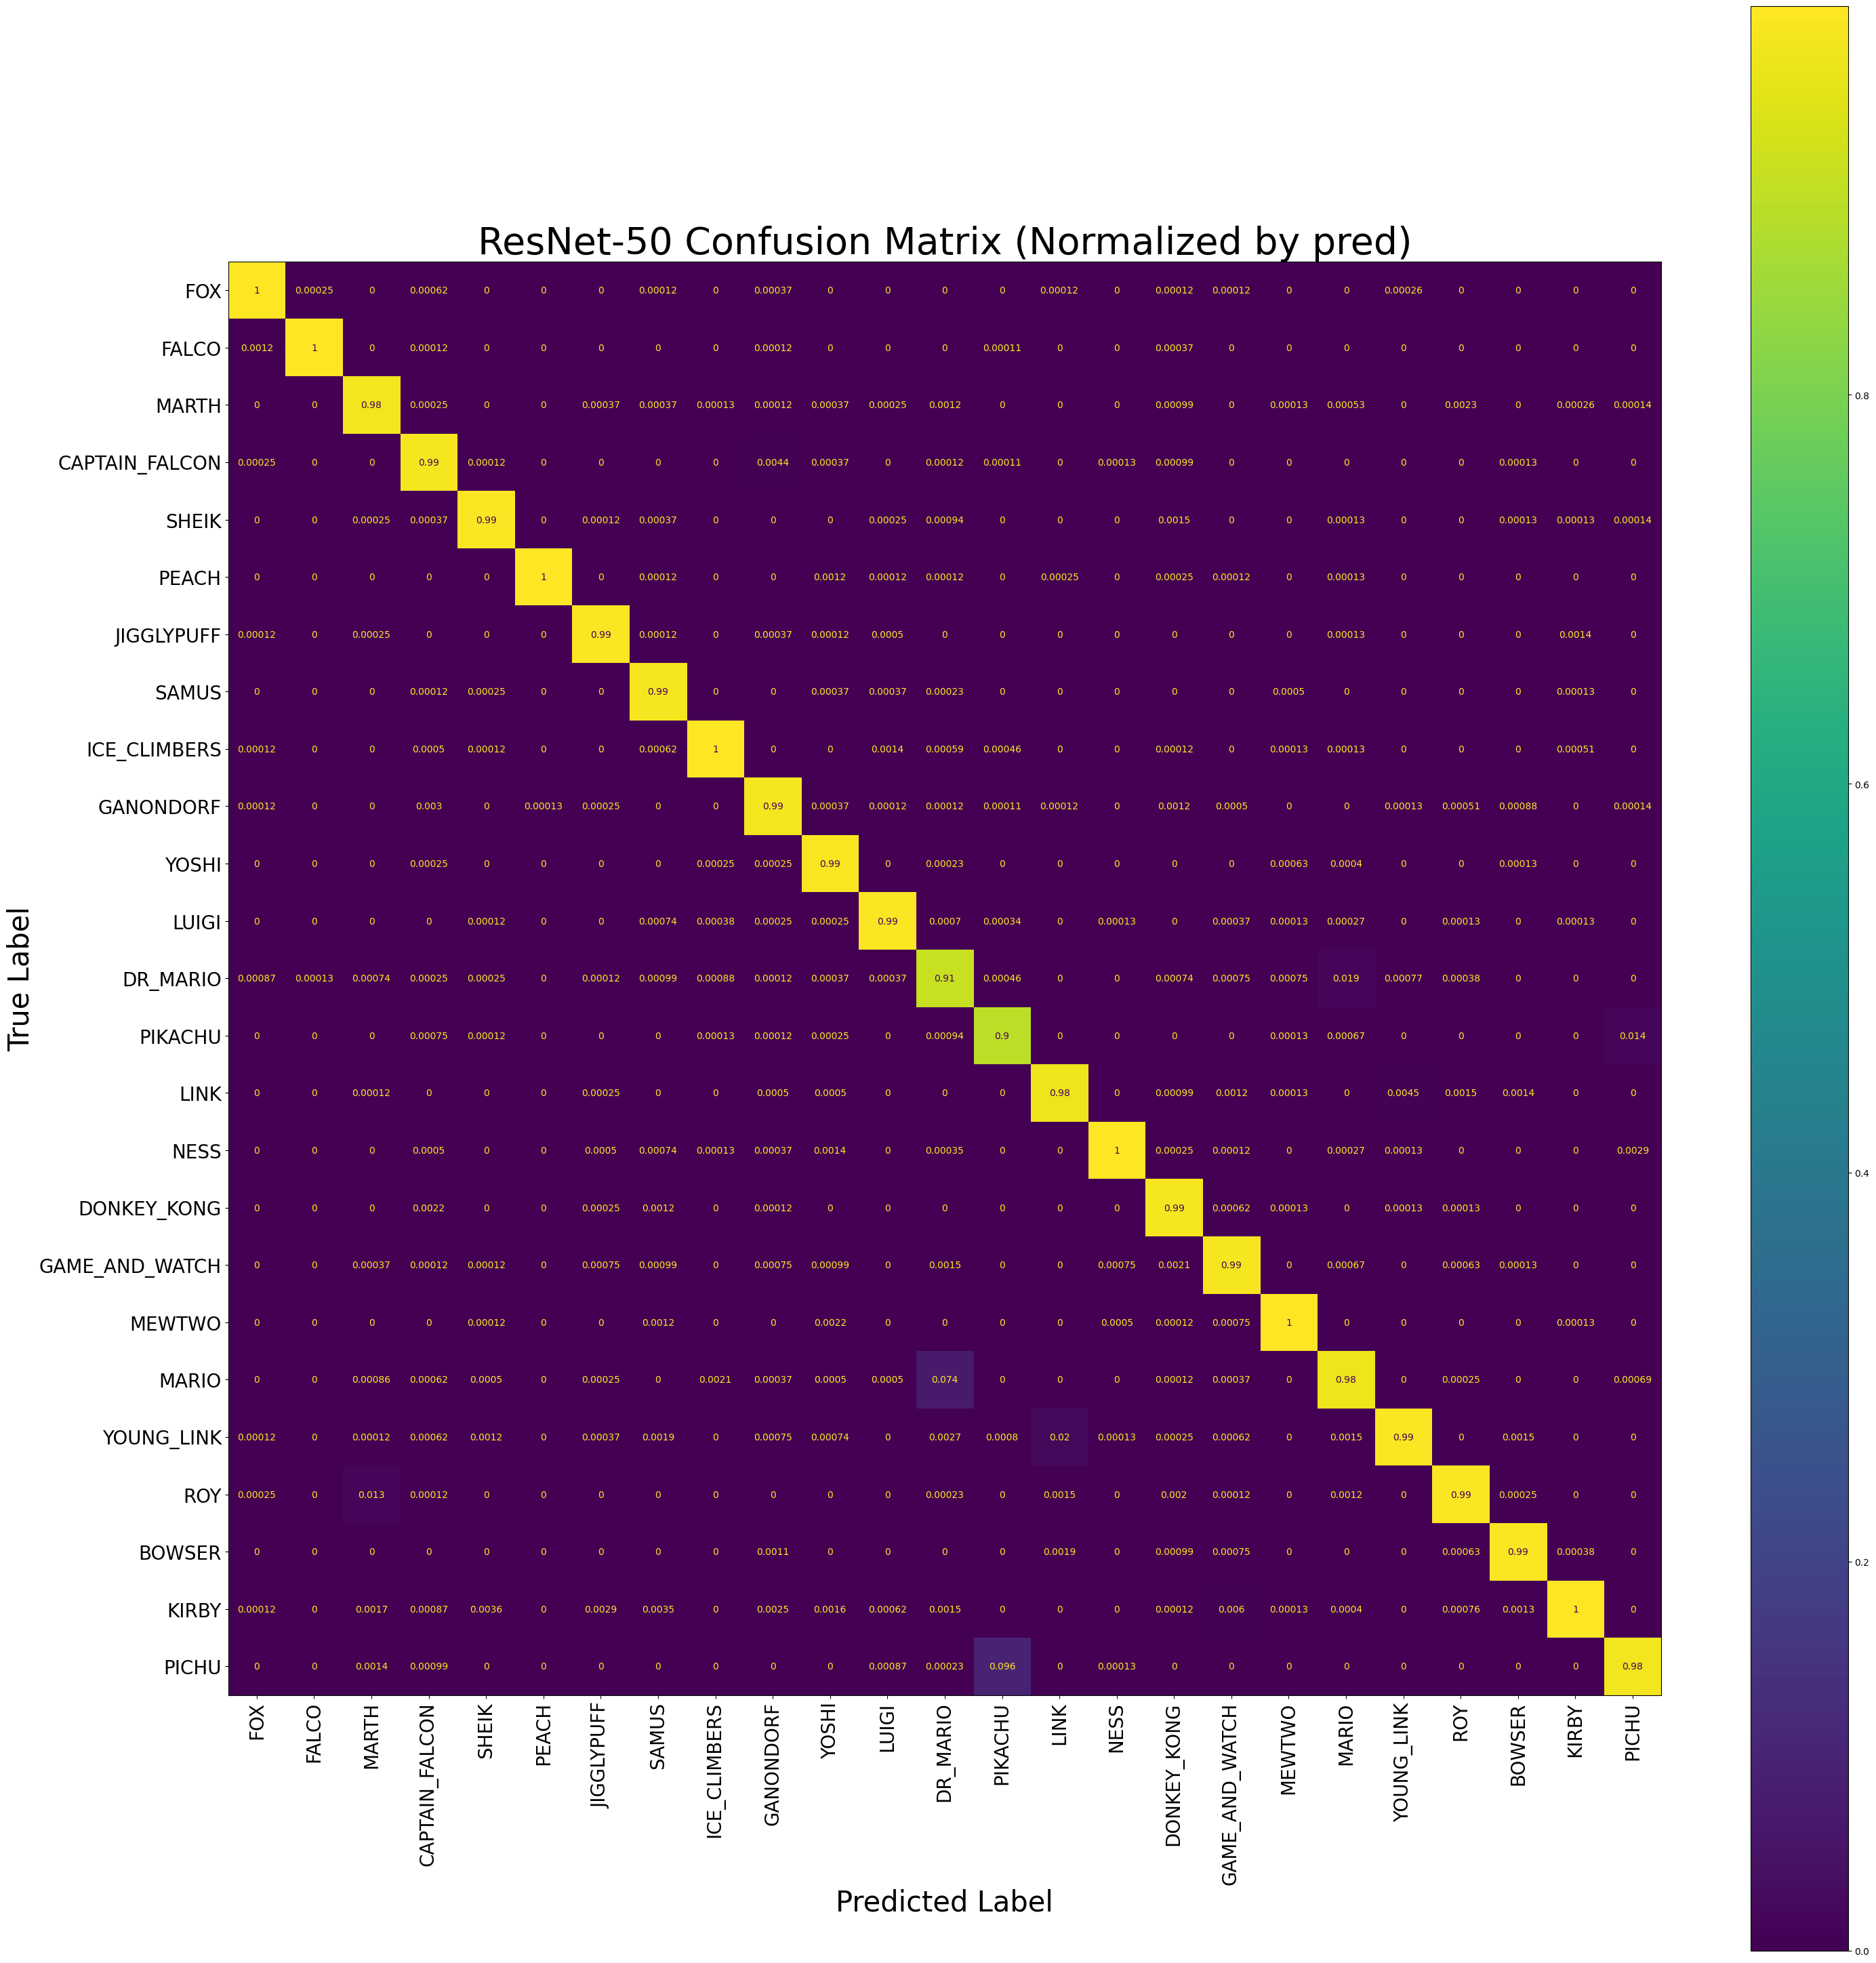

In [94]:
slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 2 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)